# MASTER DATA SCIENCE: NUCLIO

# Entregable 2: Supervised Machine Learning

El objetivo de este ejercicio es estimar la probabilidad de que una máquina con Sistema Operativo Windows se vea infectada por algún tipo de malware, en base a las distintas propiedades de la máquina.

Se han obtenido muestreando el dataset original de la competición de Kaggle Microsoft Malware Prediction, y se basan en las características obtenidas en la solución de endpoint Windows Defender. Cada fila del dataset corresponde a una máquina única, identificada por el campo MachineIdentifier. El target es la variable HasDetections, que indica que se ha detectado Malware en la máquina.

Se solicita:
1. Desarrollar el ML Canvas para este problema, suponiendo que nuestro modelo se usará para implementarlo en la aplicación Windows Defender dando aviso al usuario cuando su máquina supere un cierto umbral de probabilidad de ser infectada.
2. Desarrollar un Notebook con nuestra propuesta de modelo para resolver el problema. El Notebook debe contener todas las etapas de la ML Checklist debidamente comentadas (se valorará la claridad), y ejecutar sin problemas para obtener el modelo resultado. En concreto, debe realizarse la exploración de datos (se valorará el desarrollo de visualizaciones interesantes), el preprocesamiento, el modelado mediante un Decision Tree (opcionalmente, explorar otros algoritmos) y la evaluación.

¿En qué debo centrar mis esfuerzos para conseguir un buen proyecto?

Corrección
*   Detectar la tarea correctamente
*   Uso adecuado de algoritmo / algoritmos
*   Transformación de variables distintas
*   Partición correcta del dataset
*   Conclusiones acuradas
*   Métricas de evaluación adecuadas


Automatización
*   Eficiencia del código: evitar for loops si es posible
*   Uso de funciones en Python

Explicabilidad
*   Visualizaciones chulas
*   Plots variados
*   Razonamiento de negocio
*   Diferentes formas de explicar el resultado del modelo

### IMPORTAMOS LIBRERÍAS Y CREAMOS FUNCIONES

In [246]:
import pandas as pd  # Librería para la manipulación y el análisis de datos
# Librería para la manipulación de datos y para la ejecución de operaciones matemáticas
import numpy as np
import matplotlib.pyplot as plt  # Librería para la visualización de datos
import seaborn as sns  # Librería para la visualización de datos
# Librería para crear modelos de ML

from itertools import combinations
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
import sklearn
from sklearn import set_config
# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

# pipelines
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

set_config(transform_output="pandas")


pd.set_option("display.max_columns", None)


Creacion de funciones generales

In [247]:

def eliminar_valores(lista, valores):
    """
    Elimina de 'lista' todos los elementos que estén en 'valores'.
    """
    return [x for x in lista if x not in valores]


def eliminar_columnas(df, columnas):
    """
    Elimina de 'lista' todos los elementos que estén en un dataframe.
    """
    return df.drop(columns=columnas, errors='ignore', inplace= True)


def describe_columns(df, columns=None):
    """
    Imprime el listado de columnas y sus descripciones.

    """
    if columns is None:
        columns = df.columns.tolist()

    print("Listado de columnas y sus descripciones:\n")
    for i, col in enumerate(columns, start=1):
        description = df.attrs.get("descriptions", {}).get(
            col, "No hay descripción disponible.")
        print(f"{i}. {col}: {description}\n")


def copy_meta(df) :
    """
    Crea una copia profunda de un DataFrame incluyendo sus metadatos (df.attrs).
    """
    new_df = df.copy(deep=True)
    new_df.attrs = df.attrs.copy()

    return new_df

def obtener_lista_variables(dataset, target):
    """
    crea 3 listas indicando cuales son de las columnas de dataset sin contar el taget , cuales son boleanas , numericas y categoricas.
    """

    lista_numericas = []
    lista_boolean = []
    lista_categoricas = []

    for i in dataset:
        if (dataset[i].dtype.kind == "f" or dataset[i].dtype.kind == "i") and len(dataset[i].unique()) != 2 and (i not in target):
            lista_numericas.append(i)
        elif (dataset[i].dtype.kind == "f" or dataset[i].dtype.kind == "i") and len(dataset[i].unique()) == 2 and (i not in target):
            lista_boolean.append(i)
        elif (dataset[i].dtype.kind == "O") and i not in target:
            lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas


def umbral_columnas_nulos(dataset, columna, umbral):

    """
    crea una lista de aquellas columnas que tienen un porcentaje muy alto de nulos por encima del umbral 
    """
    lista_umnbral = []
    porcentaje_nulos_n = (
        dataset[columna].isnull().sum() / dataset.shape[0]) * 100

    for i in range(0, len(porcentaje_nulos_n)):
        if (porcentaje_nulos_n.iloc[i]) > umbral:
            lista_umnbral.append(porcentaje_nulos_n.index[i])
            print(porcentaje_nulos_n.index[i], ":", porcentaje_nulos_n.iloc[i] , "% nulos")


    return lista_umnbral


def listas_balanceadas(df, lista, umbral):
    """
    Genera 2 listas indicando cuales son las columnas que se encuentran desbalanceadas , es decir tiene una cantidad una grande de un valor por encima del umbral(90% aprox)
    """
    resultados = []
    for col in lista:
        # Calculamos el porcentaje de cada valor único
        porcentaje = df[col].value_counts(normalize=True) * 100

        # Filtrar valores que superan el umbral
        mayores_80 = porcentaje[porcentaje > umbral]

        if not mayores_80.empty:
            for valor, pct in mayores_80.items():
                print(
                    f"Columna: {col}, Valor: '{valor}', Participación: {round(pct, 2)}%")
                resultados.append((col))
    resultados = list(set(resultados))
    resultados_balencedado = eliminar_valores(lista, resultados)
    return resultados_balencedado, resultados


def segmentacion_categorias_menor_umbral(df, lista, umbral):
    """
    crea dos listas separando aquellas columnas que tienen muchos valores unicos por encima del umbral , es decir si tiene mas de 15 valores unicos por ejemplo
    """
    categorias_mayor_umbral = []
    categorias_menor_umbral = []
    for i in lista:
        if len(df[i].unique()) >= umbral:
            categorias_mayor_umbral.append(i)
        else:
            categorias_menor_umbral.append(i)
            print(i, " : ", len(df[i].unique()))
    return categorias_mayor_umbral, categorias_menor_umbral


# Filtrar correlaciones mayores al umbral (excluyendo la diagonal y duplicados)
def corr_umbral(corr, limite):
    """
    Crea un dataframe que me muestra segun el corr cual de ellos tiene un porcentaje muy alto , es decir son columnas que una puede ser eliminada porque explican lo mismo
    """
    umbral = limite/100

    corr_pairs = (
        # Mantener solo la parte superior de la matriz
        corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        # Convierte a Series con pares (col1, col2)
            .stack()
            .reset_index()                                         # Pasar a DataFrame
    )
    corr_pairs.columns = ['Columna1', 'Columna2', 'Correlacion']

    # Filtrar los pares que superen el umbral
    corr_filtrado = corr_pairs[corr_pairs['Correlacion'].abs() > umbral]
    return corr_filtrado

def pareto_por_columna(df, cols, umbral: float = 0.8):
    """
    Realiza un análisis Pareto en las columnas indicadas.
    
    Para cada columna:
      1. Calcula las frecuencias de cada valor.
      2. Ordena de mayor a menor frecuencia.
      3. Calcula el porcentaje acumulado.
      4. Devuelve los valores que acumulan hasta el umbral.

    """

    resultados = []

    for col in cols:
        if col not in df.columns:
            print(f"⚠️ La columna '{col}' no está en el DataFrame. Se omite.")
            continue

        # Conteo y porcentaje
        freq = df[col].value_counts(dropna=False)
        total = freq.sum()
        porcentaje = (freq / total) * 100

        # Acumulado
        porcentaje_acumulado = porcentaje.cumsum()

        # Filtrar hasta el umbral
        filtrados = freq.index[porcentaje_acumulado <= umbral * 100]

        for valor in filtrados:
            resultados.append({
                "Columna": col,
                "Valor": valor,
                "Frecuencia": freq[valor],
                "Porcentaje": round(porcentaje[valor], 2),
                "Acumulado": round(porcentaje_acumulado[valor], 2)
            })
    tabla_resultados = pd.DataFrame(resultados)
    conteo_valores = tabla_resultados.groupby('Columna')[
        'Valor'].nunique()
    diccionario = tabla_resultados.groupby(
        'Columna')['Valor'].apply(list).to_dict()

    print(conteo_valores)

    return tabla_resultados, conteo_valores, diccionario


def chi2_categoricas(df: pd.DataFrame, columnas: list):
    """
    Calcula el test de Chi-cuadrado para todas las combinaciones de variables categóricas.

    """
    resultados = []

    for col1, col2 in combinations(columnas, 2):
        # Crear tabla de contingencia
        tabla = pd.crosstab(df[col1], df[col2])

        # Test Chi-cuadrado
        chi2, p, dof, expected = chi2_contingency(tabla)

        resultados.append({
            'Variable1': col1,
            'Variable2': col2,
            'Chi2': chi2,
            'p_valor': p,
            'dof': dof
        })

    # Convertimos a DataFrame y ordenamos por p-valor
    df_result = pd.DataFrame(resultados)
    df_result = df_result.sort_values('p_valor').reset_index(drop=True)

    return df_result


Definicion en español de cada variable 

In [248]:
column_descriptions = {
    "MachineIdentifier": "Identificador único de la máquina.",
    "ProductName": "Información sobre el estado de Windows Defender, por ejemplo: win8defender.",
    "EngineVersion": "Versión del motor de Windows Defender, por ejemplo: 1.1.12603.0.",
    "AppVersion": "Versión de la aplicación de Windows Defender, por ejemplo: 4.9.10586.0.",
    "AvSigVersion": "Versión de las firmas antivirus de Windows Defender, por ejemplo: 1.217.1014.0.",
    "IsBeta": "Indica si la versión de Windows Defender es beta.",
    "RtpStateBitfield": "Estado de protección en tiempo real. (NA si no disponible).",
    "IsSxsPassiveMode": "Indica si Windows Defender está en modo pasivo.",
    "DefaultBrowsersIdentifier": "ID del navegador predeterminado de la máquina.",
    "AVProductStatesIdentifier": "ID de la configuración específica del software antivirus instalado.",
    "AVProductsInstalled": "Número de productos antivirus instalados. (NA si no disponible).",
    "AVProductsEnabled": "Número de productos antivirus habilitados. (NA si no disponible).",
    "HasTpm": "TRUE si la máquina tiene un módulo TPM.",
    "CountryIdentifier": "ID del país en el que se encuentra la máquina.",
    "CityIdentifier": "ID de la ciudad en la que se encuentra la máquina.",
    "OrganizationIdentifier": "ID de la organización a la que pertenece la máquina (empresa o industria).",
    "GeoNameIdentifier": "ID de la región geográfica donde se encuentra la máquina.",
    "LocaleEnglishNameIdentifier": "Nombre en inglés de la configuración regional actual del usuario.",
    "Platform": "Nombre de la plataforma basada en el sistema operativo y el procesador.",
    "Processor": "Arquitectura del procesador del sistema operativo instalado.",
    "OsVer": "Versión del sistema operativo instalada.",
    "OsBuild": "Número de compilación del sistema operativo.",
    "OsSuite": "Máscara de la suite del producto del sistema operativo.",
    "OsPlatformSubRelease": "Subversión de la plataforma del sistema operativo (por ejemplo: Windows 7, Windows 8, TH1, TH2).",
    "OsBuildLab": "Laboratorio de compilación que generó el sistema operativo. Ejemplo: 9600.17630.amd64fre.winblue_r7.150109-2022.",
    "SkuEdition": "Edición del sistema operativo según la definición de MSDN (por ejemplo: Home, Pro, Enterprise).",
    "IsProtected": "TRUE si hay un antivirus activo y actualizado. FALSE si no hay antivirus o está desactualizado. NULL si no hay productos antivirus reportados.",
    "AutoSampleOptIn": "Indica si el dispositivo permite el envío automático de muestras a Microsoft Defender.",
    "PuaMode": "Modo de protección contra aplicaciones potencialmente no deseadas (PUA).",
    "SMode": "TRUE si el dispositivo está en Windows 10 S Mode (solo permite apps de Microsoft Store).",
    "IeVerIdentifier": "Identificador de la versión de Internet Explorer. (NA si no disponible).",
    "SmartScreen": "Estado de la funcionalidad SmartScreen según el registro de Windows.",
    "Firewall": "TRUE si el firewall de Windows está habilitado (Windows 8.1 o superior).",
    "UacLuaenable": "Indica si el 'Administrador en modo de aprobación de administrador' (UAC) está habilitado.",
    "Census_MDC2FormFactor": "Agrupación basada en características de hardware que define el factor de forma del dispositivo (ej.: Smartphone, Tablet, Convertible).",
    "Census_DeviceFamily": "Clase de dispositivo a la que está destinado el sistema operativo (ej.: Windows.Desktop, Windows.Mobile, iOS.Phone).",
    "Census_OEMNameIdentifier": "Identificador del fabricante OEM. (NA si no disponible).",
    "Census_OEMModelIdentifier": "Identificador del modelo OEM. (NA si no disponible).",
    "Census_ProcessorCoreCount": "Número de núcleos lógicos del procesador.",
    "Census_ProcessorManufacturerIdentifier": "Identificador del fabricante del procesador. (NA si no disponible).",
    "Census_ProcessorModelIdentifier": "Identificador del modelo del procesador. (NA si no disponible).",
    "Census_ProcessorClass": "Clasificación de los procesadores (alta/media/baja).",
    "Census_PrimaryDiskTotalCapacity": "Capacidad total del disco primario de la máquina (en MB).",
    "Census_PrimaryDiskTypeName": "Tipo de disco primario (HDD o SSD).",
    "Census_SystemVolumeTotalCapacity": "Tamaño de la partición donde está instalado el volumen del sistema (en MB).",
    "Census_HasOpticalDiskDrive": "TRUE si el dispositivo tiene unidad de disco óptico (CD/DVD).",
    "Census_TotalPhysicalRAM": "Memoria RAM física total (en MB).",
    "Census_ChassisTypeName": "Representación numérica del tipo de chasis del dispositivo (0 = desconocido).",
    "Census_InternalPrimaryDiagonalDisplaySizeInInches": "Obtiene la longitud diagonal física en pulgadas de la pantalla principal.",
    "Census_InternalPrimaryDisplayResolutionHorizontal": "Número de píxeles en dirección horizontal de la pantalla interna.",
    "Census_InternalPrimaryDisplayResolutionVertical": "Número de píxeles en dirección vertical de la pantalla interna.",
    "Census_PowerPlatformRoleName": "Perfil de administración de energía preferido por el OEM; ayuda a identificar el factor de forma del dispositivo.",
    "Census_InternalBatteryType": "Tipo de batería interna del dispositivo. (NA si no disponible).",
    "Census_InternalBatteryNumberOfCharges": "Número estimado de ciclos de carga de la batería interna. (NA si no disponible).",
    "Census_OSVersion": "Versión numérica del sistema operativo. Ejemplo: 10.0.10130.0.",
    "Census_OSArchitecture": "Arquitectura en la que se basa el sistema operativo. Ejemplo: amd64.",
    "Census_OSBranch": "Rama del sistema operativo extraída de OsVersionFull. Ejemplo: fbl_partner_eeap.",
    "Census_OSBuildNumber": "Número de compilación del sistema operativo. Ejemplo: 10512 o 10240.",
    "Census_OSBuildRevision": "Revisión de la compilación del sistema operativo. Ejemplo: 1000 o 16458.",
    "Census_OSEdition": "Edición del sistema operativo actual. Ejemplo: Enterprise.",
    "Census_OSSkuName": "Nombre descriptivo de la edición del sistema operativo (actual solo para Windows).",
    "Census_OSInstallTypeName": "Descripción del tipo de instalación del sistema operativo (por ejemplo: limpia, actualización).",
    "Census_OSInstallLanguageIdentifier": "Identificador del idioma utilizado en la instalación del sistema operativo. (NA si no disponible).",
    "Census_OSUILocaleIdentifier": "Identificador de la configuración regional de la interfaz de usuario del sistema operativo. (NA si no disponible).",
    "Census_OSWUAutoUpdateOptionsName": "Nombre descriptivo de la configuración de actualización automática de Windows Update.",
    "Census_IsPortableOperatingSystem": "TRUE si el sistema operativo se ejecuta mediante Windows-To-Go en USB.",
    "Census_GenuineStateName": "Nombre descriptivo del estado de autenticidad del sistema operativo. 0 = Genuino.",
    "Census_ActivationChannel": "Canal de activación de la licencia (Minorista o Licencia por Volumen).",
    "Census_IsFlightingInternal": "Indica si el equipo participa en programas internos de prueba de actualizaciones. (NA si no disponible).",
    "Census_IsFlightsDisabled": "Indica si el equipo participa o no en pruebas piloto (flighting).",
    "Census_FlightRing": "Anillo de distribución de actualizaciones que el usuario desea recibir.",
    "Census_ThresholdOptIn": "Indica si el dispositivo participa en los programas Threshold. (NA si no disponible).",
    "Census_FirmwareManufacturerIdentifier": "Identificador del fabricante del firmware. (NA si no disponible).",
    "Census_FirmwareVersionIdentifier": "Identificador de la versión del firmware. (NA si no disponible).",
    "Census_IsSecureBootEnabled": "TRUE si el arranque seguro (Secure Boot) está habilitado.",
    "Census_IsWIMBootEnabled": "TRUE si el sistema utiliza WIMBoot. (NA si no disponible).",
    "Census_IsVirtualDevice": "TRUE si el dispositivo es una máquina virtual.",
    "Census_IsTouchEnabled": "TRUE si el dispositivo admite entrada táctil.",
    "Census_IsPenCapable": "TRUE si el dispositivo admite entrada mediante lápiz digital.",
    "Census_IsAlwaysOnAlwaysConnectedCapable": "TRUE si el dispositivo está diseñado para estar siempre encendido y conectado.",
    "Wdft_IsGamer": "Indica si el dispositivo está catalogado como apto para juegos según el hardware.",
    "Wdft_RegionIdentifier": "Identificador de la región del dispositivo. (NA si no disponible)."
}


## A) Descripción Inicial

In [249]:
# LEEMOS EL FICHERO
df = pd.read_csv("sample_mmp.csv", low_memory=False)


In [250]:
df.attrs["descriptions"] = column_descriptions


In [251]:
describe_columns(df)



Listado de columnas y sus descripciones:

1. Unnamed: 0: No hay descripción disponible.

2. MachineIdentifier: Identificador único de la máquina.

3. ProductName: Información sobre el estado de Windows Defender, por ejemplo: win8defender.

4. EngineVersion: Versión del motor de Windows Defender, por ejemplo: 1.1.12603.0.

5. AppVersion: Versión de la aplicación de Windows Defender, por ejemplo: 4.9.10586.0.

6. AvSigVersion: Versión de las firmas antivirus de Windows Defender, por ejemplo: 1.217.1014.0.

7. IsBeta: Indica si la versión de Windows Defender es beta.

8. RtpStateBitfield: Estado de protección en tiempo real. (NA si no disponible).

9. IsSxsPassiveMode: Indica si Windows Defender está en modo pasivo.

10. DefaultBrowsersIdentifier: ID del navegador predeterminado de la máquina.

11. AVProductStatesIdentifier: ID de la configuración específica del software antivirus instalado.

12. AVProductsInstalled: Número de productos antivirus instalados. (NA si no disponible).

13. AV

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 84 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         500000 non-null  int64  
 1   MachineIdentifier                                  500000 non-null  object 
 2   ProductName                                        500000 non-null  object 
 3   EngineVersion                                      500000 non-null  object 
 4   AppVersion                                         500000 non-null  object 
 5   AvSigVersion                                       500000 non-null  object 
 6   IsBeta                                             500000 non-null  int64  
 7   RtpStateBitfield                                   498168 non-null  float64
 8   IsSxsPassiveMode                                   500000 non-null  int64 

In [253]:
df.head(5)

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,8427007,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,2273.0,NaN,953869.0,HDD,952838.0,0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,27.0,120,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1
1,8829090,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,129,54198.0,NaN,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,248850.0,4.0,5.0,2660.0,NaN,476940.0,HDD,457600.0,0,8192.0,Notebook,13.2,1280.0,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,18.0,72,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,486.0,48753.0,0,0.0,0.0,0,0,0.0,1.0,3.0,0
2,2731904,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,windows10,x64,10.0.0.0,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,Windows.Desktop,2206.0,238234.0,4.0,5.0,2998.0,NaN,244198.0,SSD,221251.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586,1176,Core,CORE,Update,24.0,109,Notify,0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,554.0,33111.0,1,0.0,0.0,1,1,0.0,0.0,15.0,0
3,1359513,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,265410.0,8.0,5.0,2880.0,NaN,228936.0,SSD,228321.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobil

In [254]:
df.describe()

,Unnamed: 0,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,5.000000e+05,500000.000000,498168.000000,500000.000000,24061.000000,498062.000000,498062.000000,498062.000000,500000.000000,500000.000000,481760.000000,345437.000000,499984.000000,500000.000000,500000.000000,500000.000000,498074.000000,500000.000000,470152.000000,496791.000000,494838.000000,4.993770e+05,494619.000000,494236.000000,497653.000000,497653.000000,497651.000000,4.970240e+05,4.970240e+05,500000.000000,495444.000000,497346.000000,497350.000000,497350.000000,4.849620e+05,500000.000000,500000.000000,496668.000000,500000.000000,500000.000000,84775.000000,491067.000000,181896.000000,489651.000000,490939.000000,500000.000000,182334.0,499099.000000,500000.000000,500000.000000,495960.000000,483050.000000,483050.000000,500000.000000
mean,4.458888e+06,0.000002,6.846207,0.017242,1652.824529,47850.908413,1.326763,1.020714,0.987816,108.037454,81271.646027,24.869936,169.730423,122.610998,15726.933842,574.718574,0.945789,0.000028,0.000438,126.662566,0.978241,1.372503e+01,2218.646481,239128.046882,3.994074,4.529069,2370.986509,5.140433e+05,3.780546e+05,0.077034,6129.232176,16.689837,1548.304317,898.239345,1.125600e+09,15841.372572,967.224762,14.605509,60.446306,0.000522,0.000024,0.000014,0.000258,402.675943,33030.988944,0.485438,0.0,0.007067,0.125434,0.037744,0.057245,0.284060,7.888577,0.499906
std,2.575619e+06,0.001414,1.023049,0.130172,1004.754276,14023.085346,0.523000,0.166608,0.109707,63.068540,48985.129677,5.613712,89.325172,69.303165,2188.646069,248.203346,0.226433,0.005291,0.020928,42.634892,0.145895,8.995848e+03,1315.709604,72048.883577,2.071281,1.289635,842.136675,3.704468e+05,3.384722e+05,0.266646,4964.521253,5.932014,368.565945,214.862450,1.888768e+09,1959.440301,2920.627724,10.200946,45.000423,0.022841,0.004857,0.003776,0.016072,221.527124,21220.161428,0.499788,0.0,0.083766,0.331211,0.190577,0.232310,0.450966,4.551764,0.500000
min,2.000000e+00,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,1.000000,1.000000,7600.000000,16.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000e+00,54.000000,1.000000,1.000000,1.000000,3.000000,1.024000e+04,9.689000e+03,0.000000,512.000000,4.900000,-1.000000,-1.000000,0.000000e+00,9600.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.227692e+06,0.000000,7.000000,0.000000,788.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36825.000000,18.000000,89.000000,74.000000,15063.000000,256.000000,1.000000,0.000000,0.000000,111.000000,1.000000,1.000000e+00,1443.000000,189641.750000,2.000000,5.000000,1998.000000,2.393720e+05,1.207750e+05,0.000000,4096.00

In [255]:
# Identifcador de maquina no me sirve para analisis
eliminar = ['MachineIdentifier', 'Unnamed: 0']
eliminar_columnas(df, eliminar)


In [256]:
df["HasDetections"].isnull().sum()
# Identificar si tengo null en el target


0

 - Cantidad de Duplicados

In [257]:
df[df.duplicated(keep=False)]
# sin duplicados

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
4337,win8defender,1.1.15200.1,4.18.1807.18075,1.275.11.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,120,120697.0,11.0,144.0,75,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,84790.0,4.0,5.0,2703.0,NaN,488386.0,SSD,487109.0,0,8192.0,Notebook,13.9,1920.0,1080.0,Mobile,NaN,1.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,ProfessionalEducation,PROFESSIONAL,Upgrade,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,57723.0,1,NaN,0.0,0,0,0.0,0.0,3.0,0
15396,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1494.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,41,130775.0,18.0,52.0,217,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,AllInOne,Windows.Desktop,2668.0,24299.0,4.0,5.0,2710.0,NaN,953869.0,HDD,952592.0,0,4096.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,9.0,34,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,628.0,44624.0,1,NaN,0.0,0,0,0.0,0.0,10.0,1
15841,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1198.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,160,35251.0,48.0,204.0,170,windows10,x64,10.0.0.0,16299,256,rs3,16299.637.amd64fre.rs3_release_svc.180808-1748,Pro,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2102.0,241060.0,4.0,5.0,2421.0,NaN,244198.0,SSD,224776.0,0,8192.0,Desktop,24.1,1920.0,1200.0,Desktop,NaN,4.294967e+09,10.0.16299.665,amd64,rs3_release,16299,665,ProfessionalEducation,PROFESSIONAL,Other,25.0,115,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,486.0,51023.0,1,NaN,0.0,0,0,0.0,1.0,3.0,1
17354,win8defender,1.1.13504.0,4.11.15063.0,1.237.0.0,0,7.0,0,3195.0,53447.0,1.0,1.0,1,57,56452.0,NaN,76.0,222,windows10,x64,10.0.0.0,15063,256,rs2,15063.0.amd64fre.rs2_release.170317-1834,Pro,1.0,0,NaN,NaN,105.0,NaN,1.0,1.0,Desktop,Windows.Desktop,4589.0,313586.0,8.0,1.0,881.0,NaN,476940.0,HDD,200000.0,0,4096.0,Desktop,19.4,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.15063.0,amd64,rs2_release,15063,0,Professional,PROFESSIONAL,IBSClean,9.0,34,UNKNOWN,0,INVALID_LICENSE,Retail,NaN,0.0,Retail,NaN,142.0,9599.0,0,NaN,0.0,0,0,0.0,1.0,10

In [258]:
df2 = copy_meta(df)


In [259]:
df2.drop_duplicates(inplace=True)
# eliminar duplicados


### B) Analisis de Variables Boleanas , Númericas y Categoricas

In [260]:
target = ["HasDetections"]

In [261]:
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(
    df2, target)


In [262]:
print("Cantidad de columnas Totales ", len(df2.columns))
print("Cantidad de columnas númericas " , len(lista_numericas))
print("Cantidad de columnas boleanas ", len(lista_boolean))
print("Cantidad de columnas categoicas ", len(lista_categoricas))
print("Las variables target es:", target[0])


Cantidad de columnas Totales  82
Cantidad de columnas númericas  42
Cantidad de columnas boleanas  10
Cantidad de columnas categoicas  29
Las variables target es: HasDetections


 #### - Analisis de las variables Númericas

In [263]:
df2[lista_numericas].head()

,RtpStateBitfield,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,7.0,NaN,53447.0,1.0,1.0,8,85219.0,NaN,205.0,172,17134,256,1.0,0.0,137.0,1.0,1.0,1443.0,275891.0,4.0,5.0,2273.0,953869.0,952838.0,8192.0,23.0,1920.0,1080.0,4.294967e+09,17134,165,27.0,120,NaN,0.0,NaN,355.0,19951.0,0.0,0.0,0.0,11.0
1,7.0,NaN,53447.0,1.0,1.0,129,54198.0,NaN,126.0,124,17134,256,1.0,0.0,137.0,1.0,1.0,2102.0,248850.0,4.0,5.0,2660.0,476940.0,457600.0,8192.0,13.2,1280.0,720.0,0.000000e+00,17134,165,18.0,72,NaN,0.0,0.0,486.0,48753.0,0.0,0.0,1.0,3.0
2,7.0,NaN,46781.0,2.0,1.0,149,122689.0,27.0,181.0,56,10586,768,1.0,0.0,74.0,1.0,1.0,2206.0,238234.0,4.0,5.0,2998.0,244198.0,221251.0,8192.0,15.5,1920.0,1080.0,0.000000e+00,10586,1176,24.0,109,NaN,0.0,0.0,554.0,33111.0,0.0,0.0,0.0,15.0
3,7.0,NaN,53447.0,1.0,1.0,164,114587.0,27.0,205.0,172,17134,768,1.0,0.0,137.0,1.0,1.0,525.0,265410.0,8.0,5.0,2880.0,228936.0,228321.0,8192.0,15.5,1920.0,1080.0,5.770000e+02,17134,286,27.0,120,NaN,0.0,NaN,142.0,48473.0,0.0,0.0,0.0,15.0
4,7.0,NaN,47238.0,2.0,1.0,207,72421.0,27.0,277.0,75,17134,256,1.0,0.0,137.0,1.0,1.0,1443.0,256478.0,4.0,1.0,198.0,476940.0,464374.0,4096.0,15.5,1366.0,768.0,0.000000e+00,17134,228,8.0,31,NaN,0.0,NaN,355.0,4343.0,0.0,0.0,1.0,13.0


In [264]:
nulos_numericos = umbral_columnas_nulos(df2, lista_numericas , 80)


DefaultBrowsersIdentifier : 95.18845356865694 % nulos
Census_IsFlightingInternal : 83.04377915209895 % nulos


In [265]:
eliminar_columnas(df2, nulos_numericos)
lista_numericas = eliminar_valores(lista_numericas, nulos_numericos)


In [266]:
connulos = umbral_columnas_nulos(df2 ,lista_numericas , 0 )

RtpStateBitfield : 0.36642638269955435 % nulos
AVProductStatesIdentifier : 0.3876279092094631 % nulos
AVProductsInstalled : 0.3876279092094631 % nulos
AVProductsEnabled : 0.3876279092094631 % nulos
CityIdentifier : 3.647662631709483 % nulos
OrganizationIdentifier : 30.91162563704587 % nulos
GeoNameIdentifier : 0.0032002304165899944 % nulos
IsProtected : 0.38522773639702057 % nulos
SMode : 5.968829755742414 % nulos
IeVerIdentifier : 0.6418462129273308 % nulos
Firewall : 1.032474338152347 % nulos
UacLuaenable : 0.12460897184597292 % nulos
Census_OEMNameIdentifier : 1.0762774919794225 % nulos
Census_OEMModelIdentifier : 1.1528830075765455 % nulos
Census_ProcessorCoreCount : 0.4692337848325079 % nulos
Census_ProcessorManufacturerIdentifier : 0.4692337848325079 % nulos
Census_ProcessorModelIdentifier : 0.4696338136345817 % nulos
Census_PrimaryDiskTotalCapacity : 0.5950428430847021 % nulos
Census_SystemVolumeTotalCapacity : 0.5950428430847021 % nulos
Census_TotalPhysicalRAM : 0.9108655823219

In [267]:
df2[connulos].describe()


,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
count,498132.000000,498026.000000,498026.000000,498026.000000,481727.000000,345417.000000,499948.000000,498038.000000,470122.000000,496755.000000,494802.000000,4.993410e+05,494583.000000,494200.000000,497618.000000,497618.000000,497616.000000,4.969890e+05,4.969890e+05,495410.000000,497311.000000,497315.000000,497315.000000,4.849270e+05,496632.000000,491032.000000,181895.000000,489616.000000,490904.000000,499063.000000,495925.000000,483017.000000,483017.000000
mean,6.846195,47850.560541,1.326784,1.020716,81271.066276,24.869879,169.731020,0.945787,0.000438,126.662926,0.978242,1.372595e+01,2218.609340,239130.641963,3.994034,4.529044,2370.970361,5.140460e+05,3.780514e+05,6129.160885,16.689700,1548.297900,898.235456,1.125451e+09,14.605436,0.000014,0.000258,402.678127,33031.425391,0.007065,0.057247,0.284062,7.888637
std,1.023085,14023.426963,0.523011,0.166614,48985.630400,5.613194,89.325934,0.226437,0.020928,42.636134,0.145893,8.996172e+03,1315.714492,72045.809119,2.071276,1.289665,842.154420,3.704454e+05,3.384684e+05,4964.475670,5.932102,368.568377,214.865149,1.888688e+09,10.200954,0.003776,0.016073,221.527339,21220.270308,0.083758,0.232313,0.450967,4.551759
min,0.000000,3.000000,1.000000,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,8.000000,0.000000,0.000000e+00,54.000000,1.000000,1.000000,1.000000,3.000000,1.024000e+04,9.689000e+03,512.000000,4.900000,-1.000000,-1.000000,0.000000e+00,1.000000,0.000000,0.000000,11.000000,10.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,49480.000000,1.000000,1.000000,36825.000000,18.000000,89.000000,1.000000,0.000000,111.000000,1.000000,1.000000e+00,1443.000000,189642.000000,2.000000,5.000000,1998.000000,2.393720e+05,1.207750e+05,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,8.000000,0.000000,0.000000,142.000000,13156.000000,0.000000,0.000000,0.000000,3.000000
50%,7.000000,53447.000000,1.000000,1.000000,82373.000000,27.000000,181.000000,1.000000,0.000000,135.000000,1.000000,1.000000e+00,2102.000000,247520.000000,4.000000,5.000000,2500.000000,4.769400e+05,2.494500e+05,4096.000000,15.500000,1366.000000,768.000000,0.000000e+00,9.000000,0.000000,0.000000,500.000000,33070.000000,0.000000,0.000000,0.000000,10.000000
75%,7.000000,53447.000000,2.000000,1.000000,123938.000000,27.000000,267.000000,1.000000,0.000000,137.000000,1.000000,1.000000e+00,2668.000000,304438.000000,4.000000,5.000000,2877.000000,9.538690e+05,4.759810e+05,8192.000000,17.200000,1920.000000,1080.000000,4.294967e+09,20.000000,0.000000,0.000000,556.000000,52436.000000,0.000000,0.000000,1.000000,11.000000
max,35.000000,70492.000000,5.000000,4.000000,167958.000000,52.000000,296.000000,1.000000,1.000000,429.000000,1.000000,6.357062e+06,6143.000000,345493.000000,88.000000,10.000000,4472.000000,4.768767e+07,4.768710e+07,393216.000000,142.000000,11520.000000,4320.000000,4.294967e+09,39.000000,1.000000,1.000000,1084.000000,72091.000000,1.000000,1.000000,1.000000,15.000000


In [268]:
corr = df2[lista_numericas].corr(numeric_only=True)
corr_umbral(corr ,70)


,Columna1,Columna2,Correlacion
333,OsBuild,Census_OSBuildNumber,0.937658
569,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,0.799113
608,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,0.778395
674,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,0.898249
734,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,0.988489


In [269]:
describe_columns(df2, ['OsBuild', 'Census_OSBuildNumber',
                 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier'])


Listado de columnas y sus descripciones:

1. OsBuild: Número de compilación del sistema operativo.

2. Census_OSBuildNumber: Número de compilación del sistema operativo. Ejemplo: 10512 o 10240.

3. Census_ProcessorManufacturerIdentifier: Identificador del fabricante del procesador. (NA si no disponible).

4. Census_ProcessorModelIdentifier: Identificador del modelo del procesador. (NA si no disponible).

5. Census_PrimaryDiskTotalCapacity: Capacidad total del disco primario de la máquina (en MB).

6. Census_SystemVolumeTotalCapacity: Tamaño de la partición donde está instalado el volumen del sistema (en MB).

7. Census_InternalPrimaryDisplayResolutionHorizontal: Número de píxeles en dirección horizontal de la pantalla interna.

8. Census_InternalPrimaryDisplayResolutionVertical: Número de píxeles en dirección vertical de la pantalla interna.

9. Census_OSInstallLanguageIdentifier: Identificador del idioma utilizado en la instalación del sistema operativo. (NA si no disponible).

10. Ce

In [270]:
# Eliminar alta correlacion en numericas 
elimino_col = ['Census_OSBuildNumber', 'Census_ProcessorManufacturerIdentifier', 'Census_PrimaryDiskTotalCapacity' , 
               'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_OSInstallLanguageIdentifier']

eliminar_columnas(df2, elimino_col)
lista_numericas = eliminar_valores(lista_numericas, elimino_col)


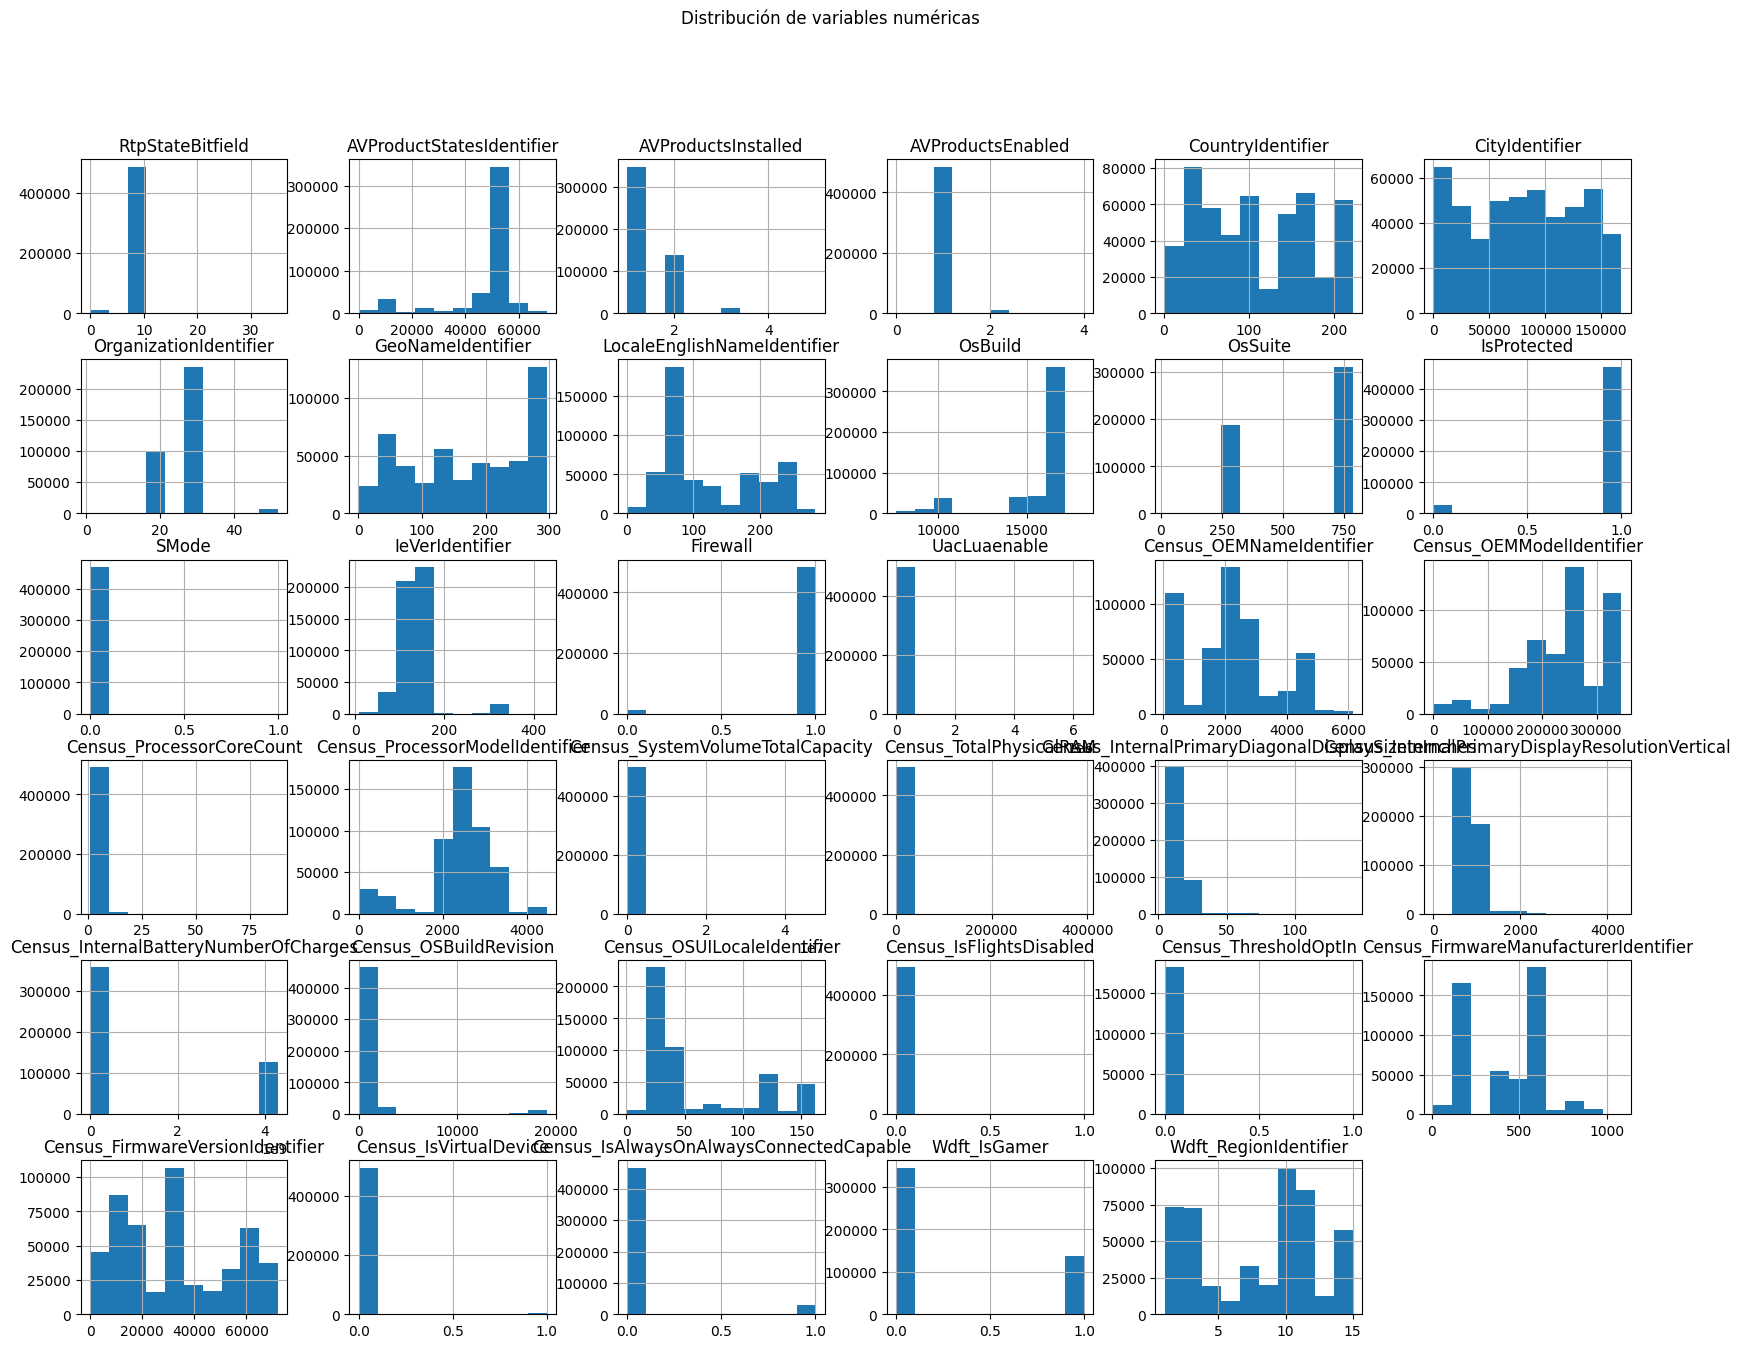

In [271]:


numericas = lista_numericas  # Para no explotar visualmente

df2[numericas].hist(bins=10, figsize=(20, 15))
plt.suptitle("Distribución de variables numéricas")
plt.show()


In [272]:
lista_numericas_interesantes = ['AVProductStatesIdentifier', 'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'IeVerIdentifier', 'Census_OEMModelIdentifier', 'Census_OEMNameIdentifier', 'Census_ProcessorModelIdentifier', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_OSUILocaleIdentifier', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Wdft_RegionIdentifier']


 #### - Analisis de las variables Boleanas

In [273]:
df2[lista_boolean].head()


,IsBeta,IsSxsPassiveMode,HasTpm,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable
0,0,0,1,0,0,0,0,NaN,0,0
1,0,0,1,0,0,0,0,0.0,0,0
2,0,0,1,0,0,0,1,0.0,1,1
3,0,0,1,0,0,0,1,NaN,0,0
4,0,0,1,0,0,0,1,NaN,1,0


In [274]:
nulos_boleanos = umbral_columnas_nulos(df2, lista_boolean, 0)


Census_IsWIMBootEnabled : 63.530774215743534 % nulos


In [275]:
df['Census_IsWIMBootEnabled'].value_counts()


Census_IsWIMBootEnabled
0.0    182334
Name: count, dtype: int64

In [276]:
# es mejor eliminar columna Census_IsWIMBootEnabled :

eliminar_columnas(df2, nulos_boleanos)
lista_boolean = eliminar_valores(lista_boolean, nulos_boleanos)


In [277]:
print(lista_boolean)


['IsBeta', 'IsSxsPassiveMode', 'HasTpm', 'AutoSampleOptIn', 'Census_HasOpticalDiskDrive', 'Census_IsPortableOperatingSystem', 'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled', 'Census_IsPenCapable']


In [278]:
df2[lista_boolean].head(5)

,IsBeta,IsSxsPassiveMode,HasTpm,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,1,1,1
3,0,0,1,0,0,0,1,0,0
4,0,0,1,0,0,0,1,1,0


In [279]:
balanceados_boleanos , no_balanceados_boleanos = listas_balanceadas(df2,lista_boolean , 90)

Columna: IsBeta, Valor: '0', Participación: 100.0%
Columna: IsSxsPassiveMode, Valor: '0', Participación: 98.28%
Columna: HasTpm, Valor: '1', Participación: 98.78%
Columna: AutoSampleOptIn, Valor: '0', Participación: 100.0%
Columna: Census_HasOpticalDiskDrive, Valor: '0', Participación: 92.3%
Columna: Census_IsPortableOperatingSystem, Valor: '0', Participación: 99.95%
Columna: Census_IsPenCapable, Valor: '0', Participación: 96.23%


In [280]:
print("Columnas mas balanceadas : " ,balanceados_boleanos)
print("Columnas no balanceadas : " ,no_balanceados_boleanos)


Columnas mas balanceadas :  ['Census_IsSecureBootEnabled', 'Census_IsTouchEnabled']
Columnas no balanceadas :  ['IsSxsPassiveMode', 'IsBeta', 'Census_IsPortableOperatingSystem', 'Census_IsPenCapable', 'Census_HasOpticalDiskDrive', 'HasTpm', 'AutoSampleOptIn']


In [281]:
listas_balanceadas(df2,balanceados_boleanos , 0)

Columna: Census_IsSecureBootEnabled, Valor: '0', Participación: 51.46%
Columna: Census_IsSecureBootEnabled, Valor: '1', Participación: 48.54%
Columna: Census_IsTouchEnabled, Valor: '0', Participación: 87.46%
Columna: Census_IsTouchEnabled, Valor: '1', Participación: 12.54%


([], ['Census_IsSecureBootEnabled', 'Census_IsTouchEnabled'])

In [282]:
eliminar_columnas(df2, no_balanceados_boleanos)
lista_boolean =eliminar_valores(lista_boolean ,no_balanceados_boleanos )

In [283]:
describe_columns(df2 , lista_boolean)
print(lista_boolean)

Listado de columnas y sus descripciones:

1. Census_IsSecureBootEnabled: TRUE si el arranque seguro (Secure Boot) está habilitado.

2. Census_IsTouchEnabled: TRUE si el dispositivo admite entrada táctil.

['Census_IsSecureBootEnabled', 'Census_IsTouchEnabled']


 #### - Analisis de las variables Categoricas

In [284]:
df2[lista_categoricas].head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,PuaMode,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,HDD,AllinOne,Desktop,NaN,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail
1,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,lion,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail
2,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,windows10,x64,10.0.0.0,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,NaN,RequireAdmin,Convertible,Windows.Desktop,NaN,SSD,Notebook,Mobile,lion,10.0.10586.1176,amd64,th2_release_sec,Core,CORE,Update,Notify,IS_GENUINE,Retail,Retail
3,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,NaN,Notebook,Windows.Desktop,NaN,SSD,Notebook,Mobile,NaN,10.0.17134.286,amd64,rs4_release,Core,CORE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail
4,win8defender,1.1.15200.1,4.18.1807.18075,1.275.511.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Portable,Mobile,NaN,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,Update,FullAuto,IS_GENUINE,OEM:DM,Retail


In [285]:
nulos_categoricas =umbral_columnas_nulos(df2,lista_categoricas , 80)

PuaMode : 99.97479818546935 % nulos
Census_ProcessorClass : 99.58357001704123 % nulos


In [286]:
eliminar_columnas(df2 , nulos_categoricas)
lista_categoricas = eliminar_valores(lista_categoricas , nulos_categoricas)

In [287]:
balanceados_categoricos ,  no_balanceados_categoricos = listas_balanceadas(df, lista_categoricas, 90)


Columna: ProductName, Valor: 'win8defender', Participación: 98.92%
Columna: Platform, Valor: 'windows10', Participación: 96.61%
Columna: Processor, Valor: 'x64', Participación: 90.88%
Columna: OsVer, Valor: '10.0.0.0', Participación: 96.77%
Columna: Census_DeviceFamily, Valor: 'Windows.Desktop', Participación: 99.84%
Columna: Census_OSArchitecture, Valor: 'amd64', Participación: 90.89%
Columna: Census_FlightRing, Valor: 'Retail', Participación: 93.66%


In [288]:
eliminar_columnas(df2, no_balanceados_categoricos)
lista_categoricas = eliminar_valores(
    lista_categoricas, no_balanceados_categoricos)
# elimina aquellas categorias poco balanceadas


In [289]:
# describe_columns(df2, lista_categoricas)
print(lista_categoricas)


['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel']


In [290]:
categorias_uniq_mayor , categorias_uniq_menor = segmentacion_categorias_menor_umbral(df2 ,lista_categoricas , 15 )
# Divido las categorias por aquellas con valores unicos menores a 15

OsPlatformSubRelease  :  9
SkuEdition  :  8
SmartScreen  :  13
Census_MDC2FormFactor  :  12
Census_PrimaryDiskTypeName  :  5
Census_PowerPlatformRoleName  :  10
Census_OSInstallTypeName  :  9
Census_OSWUAutoUpdateOptionsName  :  6
Census_GenuineStateName  :  4
Census_ActivationChannel  :  6


In [291]:
print("columnas con mas de 15 valores unicos: ",  categorias_uniq_mayor)
print("\n columnas con menos de 15 valores unicos: ", categorias_uniq_menor)


columnas con mas de 15 valores unicos:  ['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsBuildLab', 'Census_ChassisTypeName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName']

 columnas con menos de 15 valores unicos:  ['OsPlatformSubRelease', 'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_PowerPlatformRoleName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel']


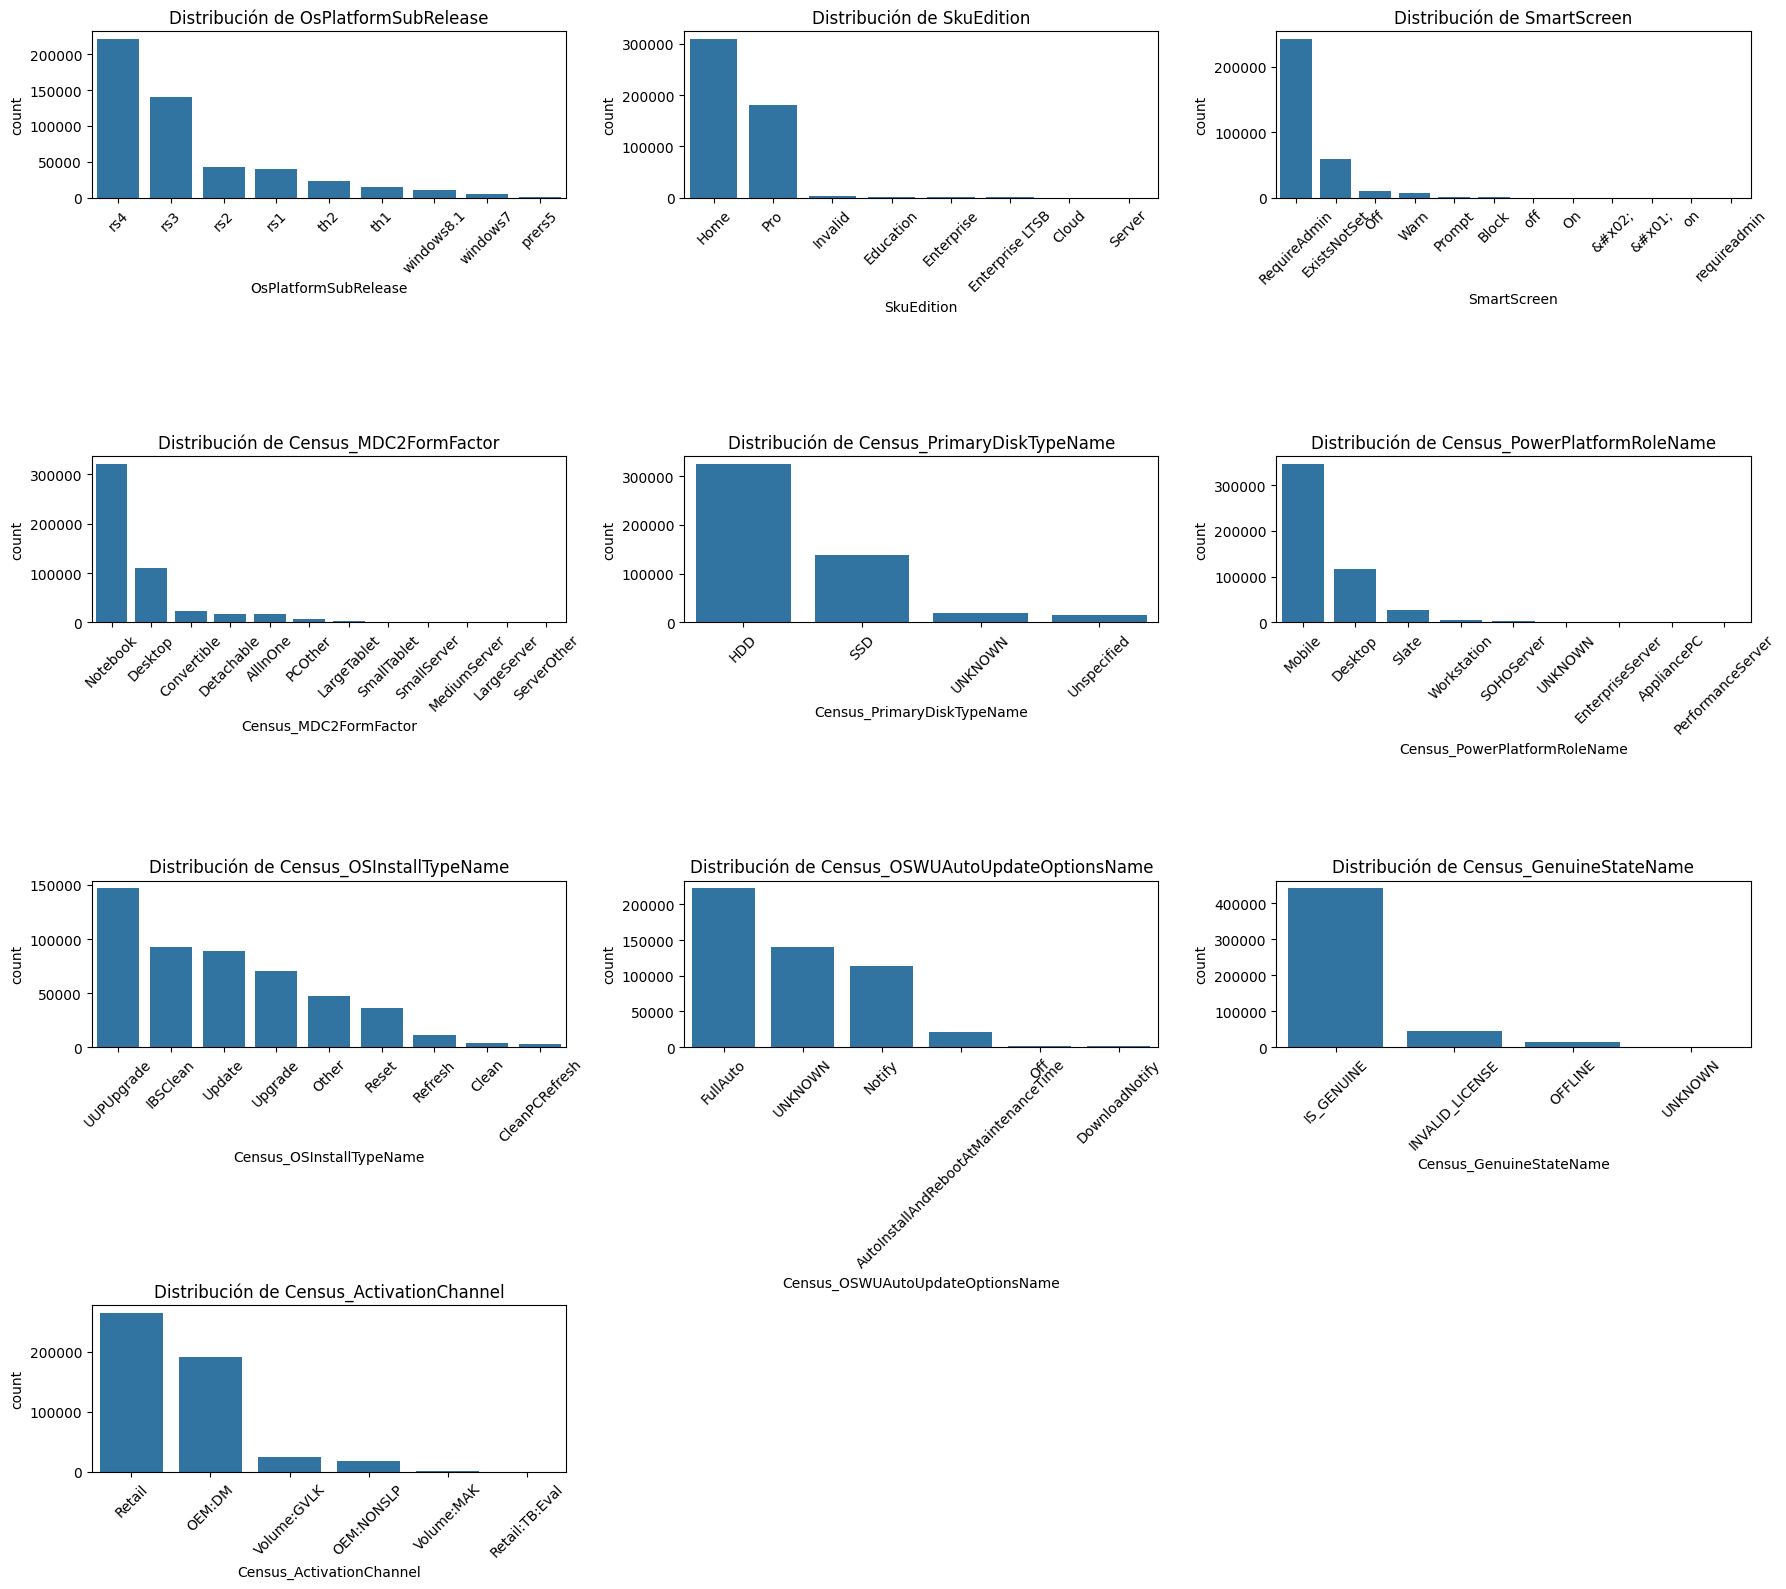

In [292]:
n_cols = 3
n_rows = (len(categorias_uniq_menor) + n_cols -
          1) // n_cols  # Calcula filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
axes = axes.flatten()  # Facilita iterar aunque haya solo 1 fila

for i, col in enumerate(categorias_uniq_menor):
    sns.countplot(x=df[col], order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos si hay menos columnas que celdas
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [293]:
describe_columns(df2 ,categorias_uniq_menor )

Listado de columnas y sus descripciones:

1. OsPlatformSubRelease: Subversión de la plataforma del sistema operativo (por ejemplo: Windows 7, Windows 8, TH1, TH2).

2. SkuEdition: Edición del sistema operativo según la definición de MSDN (por ejemplo: Home, Pro, Enterprise).

3. SmartScreen: Estado de la funcionalidad SmartScreen según el registro de Windows.

4. Census_MDC2FormFactor: Agrupación basada en características de hardware que define el factor de forma del dispositivo (ej.: Smartphone, Tablet, Convertible).

5. Census_PrimaryDiskTypeName: Tipo de disco primario (HDD o SSD).

6. Census_PowerPlatformRoleName: Perfil de administración de energía preferido por el OEM; ayuda a identificar el factor de forma del dispositivo.

7. Census_OSInstallTypeName: Descripción del tipo de instalación del sistema operativo (por ejemplo: limpia, actualización).

8. Census_OSWUAutoUpdateOptionsName: Nombre descriptivo de la configuración de actualización automática de Windows Update.

9. Census

Analisas las categorias con muchos valores unicos

In [294]:
# Copia antes de transformacion de categoricas 
df3 = copy_meta(df2)

In [295]:
df3.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,1.1.15100.1,4.18.1807.18075,1.273.1234.0,7.0,53447.0,1.0,1.0,8,85219.0,NaN,205.0,172,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,1443.0,275891.0,4.0,2273.0,HDD,952838.0,8192.0,AllinOne,23.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,165,Professional,PROFESSIONAL,UUPUpgrade,120,FullAuto,IS_GENUINE,OEM:DM,0.0,NaN,355.0,19951.0,0,0.0,0,0.0,0.0,11.0,1
1,1.1.15100.1,4.18.1807.18075,1.273.1282.0,7.0,53447.0,1.0,1.0,129,54198.0,NaN,126.0,124,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,2102.0,248850.0,4.0,2660.0,HDD,457600.0,8192.0,Notebook,13.2,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,rs4_release,165,Professional,PROFESSIONAL,UUPUpgrade,72,FullAuto,IS_GENUINE,OEM:DM,0.0,0.0,486.0,48753.0,0,0.0,0,0.0,1.0,3.0,0
2,1.1.15100.1,4.9.10586.1106,1.273.781.0,7.0,46781.0,2.0,1.0,149,122689.0,27.0,181.0,56,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,2206.0,238234.0,4.0,2998.0,SSD,221251.0,8192.0,Notebook,15.5,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,th2_release_sec,1176,Core,CORE,Update,109,Notify,IS_GENUINE,Retail,0.0,0.0,554.0,33111.0,1,0.0,1,0.0,0.0,15.0,0
3,1.1.15200.1,4.18.1807.18075,1.275.1639.0,7.0,53447.0,1.0,1.0,164,114587.0,27.0,205.0,172,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0.0,137.0,NaN,1.0,1.0,Notebook,525.0,265410.0,8.0,2880.0,SSD,228321.0,8192.0,Notebook,15.5,1080.0,Mobile,NaN,5.770000e+02,10.0.17134.286,rs4_release,286,Core,CORE,IBSClean,120,FullAuto,IS_GENUINE,Retail,0.0,NaN,142.0,48473.0,1,0.0,0,0.0,0.0,15.0,1
4,1.1.15200.1,4.18.1807.18075,1.275.511.0,7.0,47238.0,2.0,1.0,207,72421.0,27.0,277.0,75,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,1443.0,256478.0,4.0,198.0,HDD,464374.0,4096.0,Portable,15.5,768.0,Mobile,NaN,0.000000e+00,10.0.17134.228,rs4_release,228,Professional,PROFESSIONAL,Update,31,FullAuto,IS_GENUINE,OEM:DM,0.0,NaN,355.0,4343.0,1,0.0,1,0.0,1.0,13.0,1


Evaluar lista columnas con mas de 15 valores unicos :

In [296]:
# Solo columnas categóricas

df3[lista_categoricas] = df3[lista_categoricas].fillna("Otros")


In [297]:
df3[categorias_uniq_mayor].head(5)

,EngineVersion,AppVersion,AvSigVersion,OsBuildLab,Census_ChassisTypeName,Census_InternalBatteryType,Census_OSVersion,Census_OSBranch,Census_OSEdition,Census_OSSkuName
0,1.1.15100.1,4.18.1807.18075,1.273.1234.0,17134.1.amd64fre.rs4_release.180410-1804,AllinOne,Otros,10.0.17134.165,rs4_release,Professional,PROFESSIONAL
1,1.1.15100.1,4.18.1807.18075,1.273.1282.0,17134.1.amd64fre.rs4_release.180410-1804,Notebook,lion,10.0.17134.165,rs4_release,Professional,PROFESSIONAL
2,1.1.15100.1,4.9.10586.1106,1.273.781.0,10586.1176.amd64fre.th2_release_sec.170913-1848,Notebook,lion,10.0.10586.1176,th2_release_sec,Core,CORE
3,1.1.15200.1,4.18.1807.18075,1.275.1639.0,17134.1.amd64fre.rs4_release.180410-1804,Notebook,Otros,10.0.17134.286,rs4_release,Core,CORE
4,1.1.15200.1,4.18.1807.18075,1.275.511.0,17134.1.amd64fre.rs4_release.180410-1804,Portable,Otros,10.0.17134.228,rs4_release,Professional,PROFESSIONAL


In [298]:
tabla_pareto , resumen_pareto , listas_valores_categoricos = pareto_por_columna(df3 , categorias_uniq_mayor ,0.95)
# realizo un parteo para saber donde se encuentra el 95% de su total 

Columna
AppVersion                      15
AvSigVersion                  1396
Census_ChassisTypeName           6
Census_InternalBatteryType       2
Census_OSBranch                  6
Census_OSEdition                 2
Census_OSSkuName                 2
Census_OSVersion                76
EngineVersion                    7
OsBuildLab                      43
Name: Valor, dtype: int64


In [299]:
describe_columns(df3, ['AvSigVersion', 'Census_OSVersion',
                 'OsBuildLab'])


Listado de columnas y sus descripciones:

1. AvSigVersion: Versión de las firmas antivirus de Windows Defender, por ejemplo: 1.217.1014.0.

2. Census_OSVersion: Versión numérica del sistema operativo. Ejemplo: 10.0.10130.0.

3. OsBuildLab: Laboratorio de compilación que generó el sistema operativo. Ejemplo: 9600.17630.amd64fre.winblue_r7.150109-2022.




Analizaremos las variables de chi2 para ver cuales tienen mayor relacion

In [300]:
chi2_resutado  =  chi2_categoricas(df3 , lista_categoricas)

In [301]:
print(chi2_resutado[chi2_resutado['p_valor'] < 0.05]
      ['Variable1'].dropna().unique())


['EngineVersion' 'Census_MDC2FormFactor' 'Census_PrimaryDiskTypeName'
 'Census_ChassisTypeName' 'SkuEdition' 'SmartScreen' 'Census_OSVersion'
 'Census_OSBranch' 'Census_OSEdition' 'Census_OSSkuName'
 'Census_OSInstallTypeName' 'Census_OSWUAutoUpdateOptionsName'
 'Census_PowerPlatformRoleName' 'Census_InternalBatteryType' 'AppVersion'
 'AvSigVersion' 'OsPlatformSubRelease' 'OsBuildLab'
 'Census_GenuineStateName']


Quiero relacionar las columnas con mayor valores unicos con las columnas con menores valores unicos ara saber si su pvalue es menor a 0.05 y asi remplazar las columnas con grandes volumenes de valores unicos por una de pocos

In [302]:
lista_eliminar_part1 = chi2_resutado[(chi2_resutado['Variable2'].isin(categorias_uniq_menor)) & (chi2_resutado['Variable1'].isin(categorias_uniq_mayor)) &
                    (chi2_resutado['p_valor'] < 0.05)]['Variable1'].dropna().unique().tolist()

lista_eliminar_part1


['Census_ChassisTypeName',
 'Census_OSVersion',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_InternalBatteryType',
 'AppVersion',
 'AvSigVersion',
 'EngineVersion',
 'OsBuildLab']

In [303]:
describe_columns(df2,lista_eliminar_part1)

Listado de columnas y sus descripciones:

1. Census_ChassisTypeName: Representación numérica del tipo de chasis del dispositivo (0 = desconocido).

2. Census_OSVersion: Versión numérica del sistema operativo. Ejemplo: 10.0.10130.0.

3. Census_OSBranch: Rama del sistema operativo extraída de OsVersionFull. Ejemplo: fbl_partner_eeap.

4. Census_OSEdition: Edición del sistema operativo actual. Ejemplo: Enterprise.

5. Census_OSSkuName: Nombre descriptivo de la edición del sistema operativo (actual solo para Windows).

6. Census_InternalBatteryType: Tipo de batería interna del dispositivo. (NA si no disponible).

7. AppVersion: Versión de la aplicación de Windows Defender, por ejemplo: 4.9.10586.0.

8. AvSigVersion: Versión de las firmas antivirus de Windows Defender, por ejemplo: 1.217.1014.0.

9. EngineVersion: Versión del motor de Windows Defender, por ejemplo: 1.1.12603.0.

10. OsBuildLab: Laboratorio de compilación que generó el sistema operativo. Ejemplo: 9600.17630.amd64fre.winblue_

In [304]:
chi2_resutado[(chi2_resutado['Variable2'].isin(categorias_uniq_menor)) & (chi2_resutado['Variable1'].isin(categorias_uniq_mayor)) &
              (chi2_resutado['p_valor'] < 0.05)]
# en esta tabla se puede ver que existe una relacion entre las columnas en la variable 1 muy realizionadas con las columnas de la variable 2 


,Variable1,Variable2,Chi2,p_valor,dof
15,Census_ChassisTypeName,Census_PowerPlatformRoleName,1.018389e+06,0.000000e+00,306
45,Census_ChassisTypeName,Census_OSInstallTypeName,2.947864e+04,0.000000e+00,272
46,Census_ChassisTypeName,Census_OSWUAutoUpdateOptionsName,1.093626e+05,0.000000e+00,170
47,Census_ChassisTypeName,Census_GenuineStateName,5.384865e+04,0.000000e+00,102
48,Census_OSVersion,Census_ActivationChannel,2.189769e+05,0.000000e+00,1520
...,...,...,...,...,...
166,AvSigVersion,Census_OSInstallTypeName,7.233455e+04,0.000000e+00,51632
167,AvSigVersion,Census_OSWUAutoUpdateOptionsName,5.901327e+04,0.000000e+00,32270
168,AvSigVersion,Census_GenuineStateName,3.435918e+04,0.000000e+00,19362
183,AvSigVersion,Census_PrimaryDiskTypeName,3.549953e+04,6.763759e-320,25816


In [305]:
# tienen una relacion muy grande con las variables puede ser eliminada
eliminar_columnas(df2, lista_eliminar_part1)
lista_categoricas = eliminar_valores(
    lista_categoricas, lista_eliminar_part1)
categorias_uniq_mayor = eliminar_valores(
    categorias_uniq_mayor, lista_eliminar_part1)


In [306]:
print("Todas las categorias ", len(lista_categoricas))
print("Categorias mayores a 15 valores unicos", len(categorias_uniq_mayor))
print("Categorias menores a 15 valores unicos", len(categorias_uniq_menor))


Todas las categorias  10
Categorias mayores a 15 valores unicos 0
Categorias menores a 15 valores unicos 10


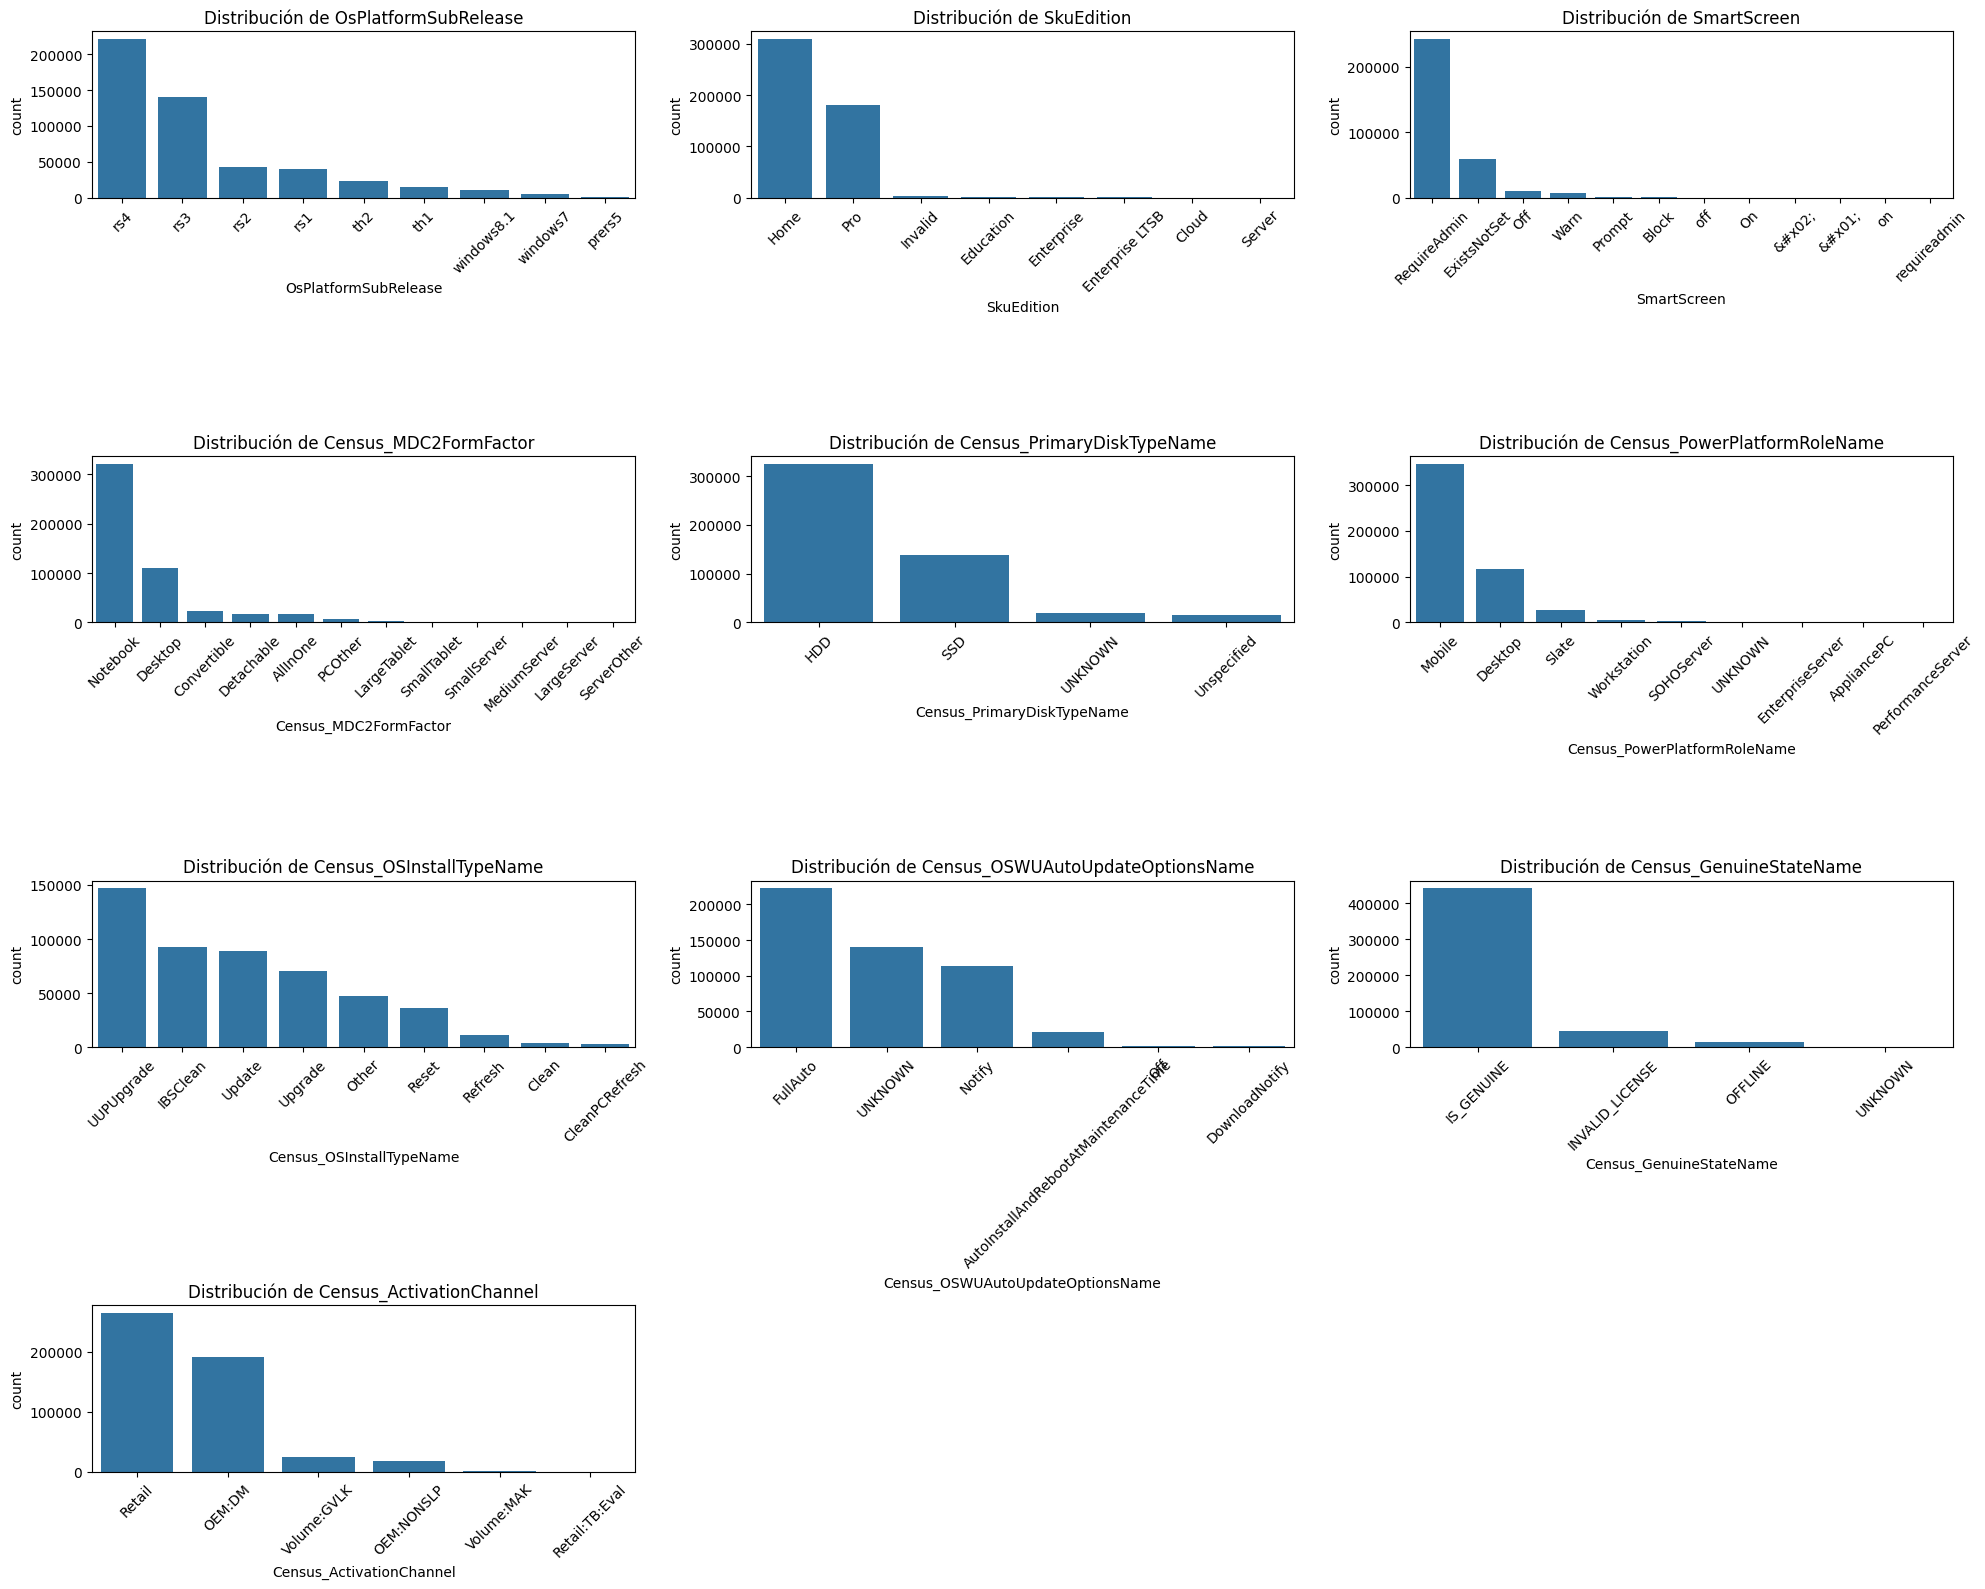

In [307]:
n_cols = 3
n_rows = (len(categorias_uniq_menor) + n_cols -
          1) // n_cols  # Calcula filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()  # Facilita iterar aunque haya solo 1 fila

for i, col in enumerate(categorias_uniq_menor):
    sns.countplot(x=df2[col], order=df2[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos si hay menos columnas que celdas
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


### C) Analisis de Variables vs Target

In [308]:
df2[target].mean()


HasDetections    0.499928
dtype: float64

In [309]:
print(type(df2[target]))

<class 'pandas.core.frame.DataFrame'>


In [310]:
df2[lista_numericas].describe()

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
count,498132.000000,498026.000000,498026.000000,498026.000000,499964.000000,481727.000000,345417.000000,499948.000000,499964.000000,499964.000000,499964.000000,498038.000000,470122.000000,496755.000000,494802.000000,4.993410e+05,494583.000000,494200.000000,497618.000000,497616.000000,4.969890e+05,495410.000000,497311.000000,497315.000000,4.849270e+05,499964.000000,499964.000000,491032.000000,181895.000000,489616.000000,490904.000000,499063.000000,495925.000000,483017.000000,483017.000000
mean,6.846195,47850.560541,1.326784,1.020716,108.037067,81271.066276,24.869879,169.731020,122.609896,15726.900769,574.736403,0.945787,0.000438,126.662926,0.978242,1.372595e+01,2218.609340,239130.641963,3.994034,2370.970361,3.780514e+05,6129.160885,16.689700,898.235456,1.125451e+09,967.237329,60.446104,0.000014,0.000258,402.678127,33031.425391,0.007065,0.057247,0.284062,7.888637
std,1.023085,14023.426963,0.523011,0.166614,63.069010,48985.630400,5.613194,89.325934,69.303037,2188.691152,248.198841,0.226437,0.020928,42.636134,0.145893,8.996172e+03,1315.714492,72045.809119,2.071276,842.154420,3.384684e+05,4964.475670,5.932102,214.865149,1.888688e+09,2920.633879,45.000444,0.003776,0.016073,221.527339,21220.270308,0.083758,0.232313,0.450967,4.551759
min,0.000000,3.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,1.000000,7600.000000,16.000000,0.000000,0.000000,8.000000,0.000000,0.000000e+00,54.000000,1.000000,1.000000,3.000000,9.689000e+03,512.000000,4.900000,-1.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,11.000000,10.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,49480.000000,1.000000,1.000000,51.000000,36825.000000,18.000000,89.000000,74.000000,15063.000000,256.000000,1.000000,0.000000,111.000000,1.000000,1.000000e+00,1443.000000,189642.000000,2.000000,1998.000000,1.207750e+05,4096.000000,13.900000,768.000000,0.000000e+00,165.000000,31.000000,0.000000,0.000000,142.000000,13156.000000,0.000000,0.000000,0.000000,3.000000
50%,7.000000,53447.000000,1.000000,1.000000,97.000000,82373.000000,27.000000,181.000000,88.000000,16299.000000,768.000000,1.000000,0.000000,135.000000,1.000000,1.000000e+00,2102.000000,247520.000000,4.000000,2500.000000,2.494500e+05,4096.000000,15.500000,768.000000,0.000000e+00,285.000000,34.000000,0.000000,0.000000,500.000000,33070.000000,0.000000,0.000000,0.000000,10.000000
75%,7.000000,53447.000000,2.000000,1.000000,162.000000,123938.000000,27.000000,267.000000,182.000000,17134.000000,768.000000,1.000000,0.000000,137.000000,1.000000,1.000000e+00,2668.000000,304438.000000,4.000000,2877.000000,4.759810e+05,8192.000000,17.200000,1080.000000,4.294967e+09,547.000000,90.000000,0.000000,0.000000,556.000000,52436.000000,0.000000,0.000000,1.000000,11.000000
max,35.000000,70492.000000,5.000000,4.000000,222.000000,167958.000000,52.000000,296.000000,283.000000,18242.000000,784.000000,1.000000,1.000000,429.000000,1.000000,6.357062e+06,6143.000000,345493.000000,88.000000,4472.000000,4.768710e+07,393216.000000,142.000000,4320.000000,4.294967e+09,19069.000000,162.000000,1.000000,1.000000,1084.000000,72091.000000,1.000000,1.000000,1.000000,15.000000


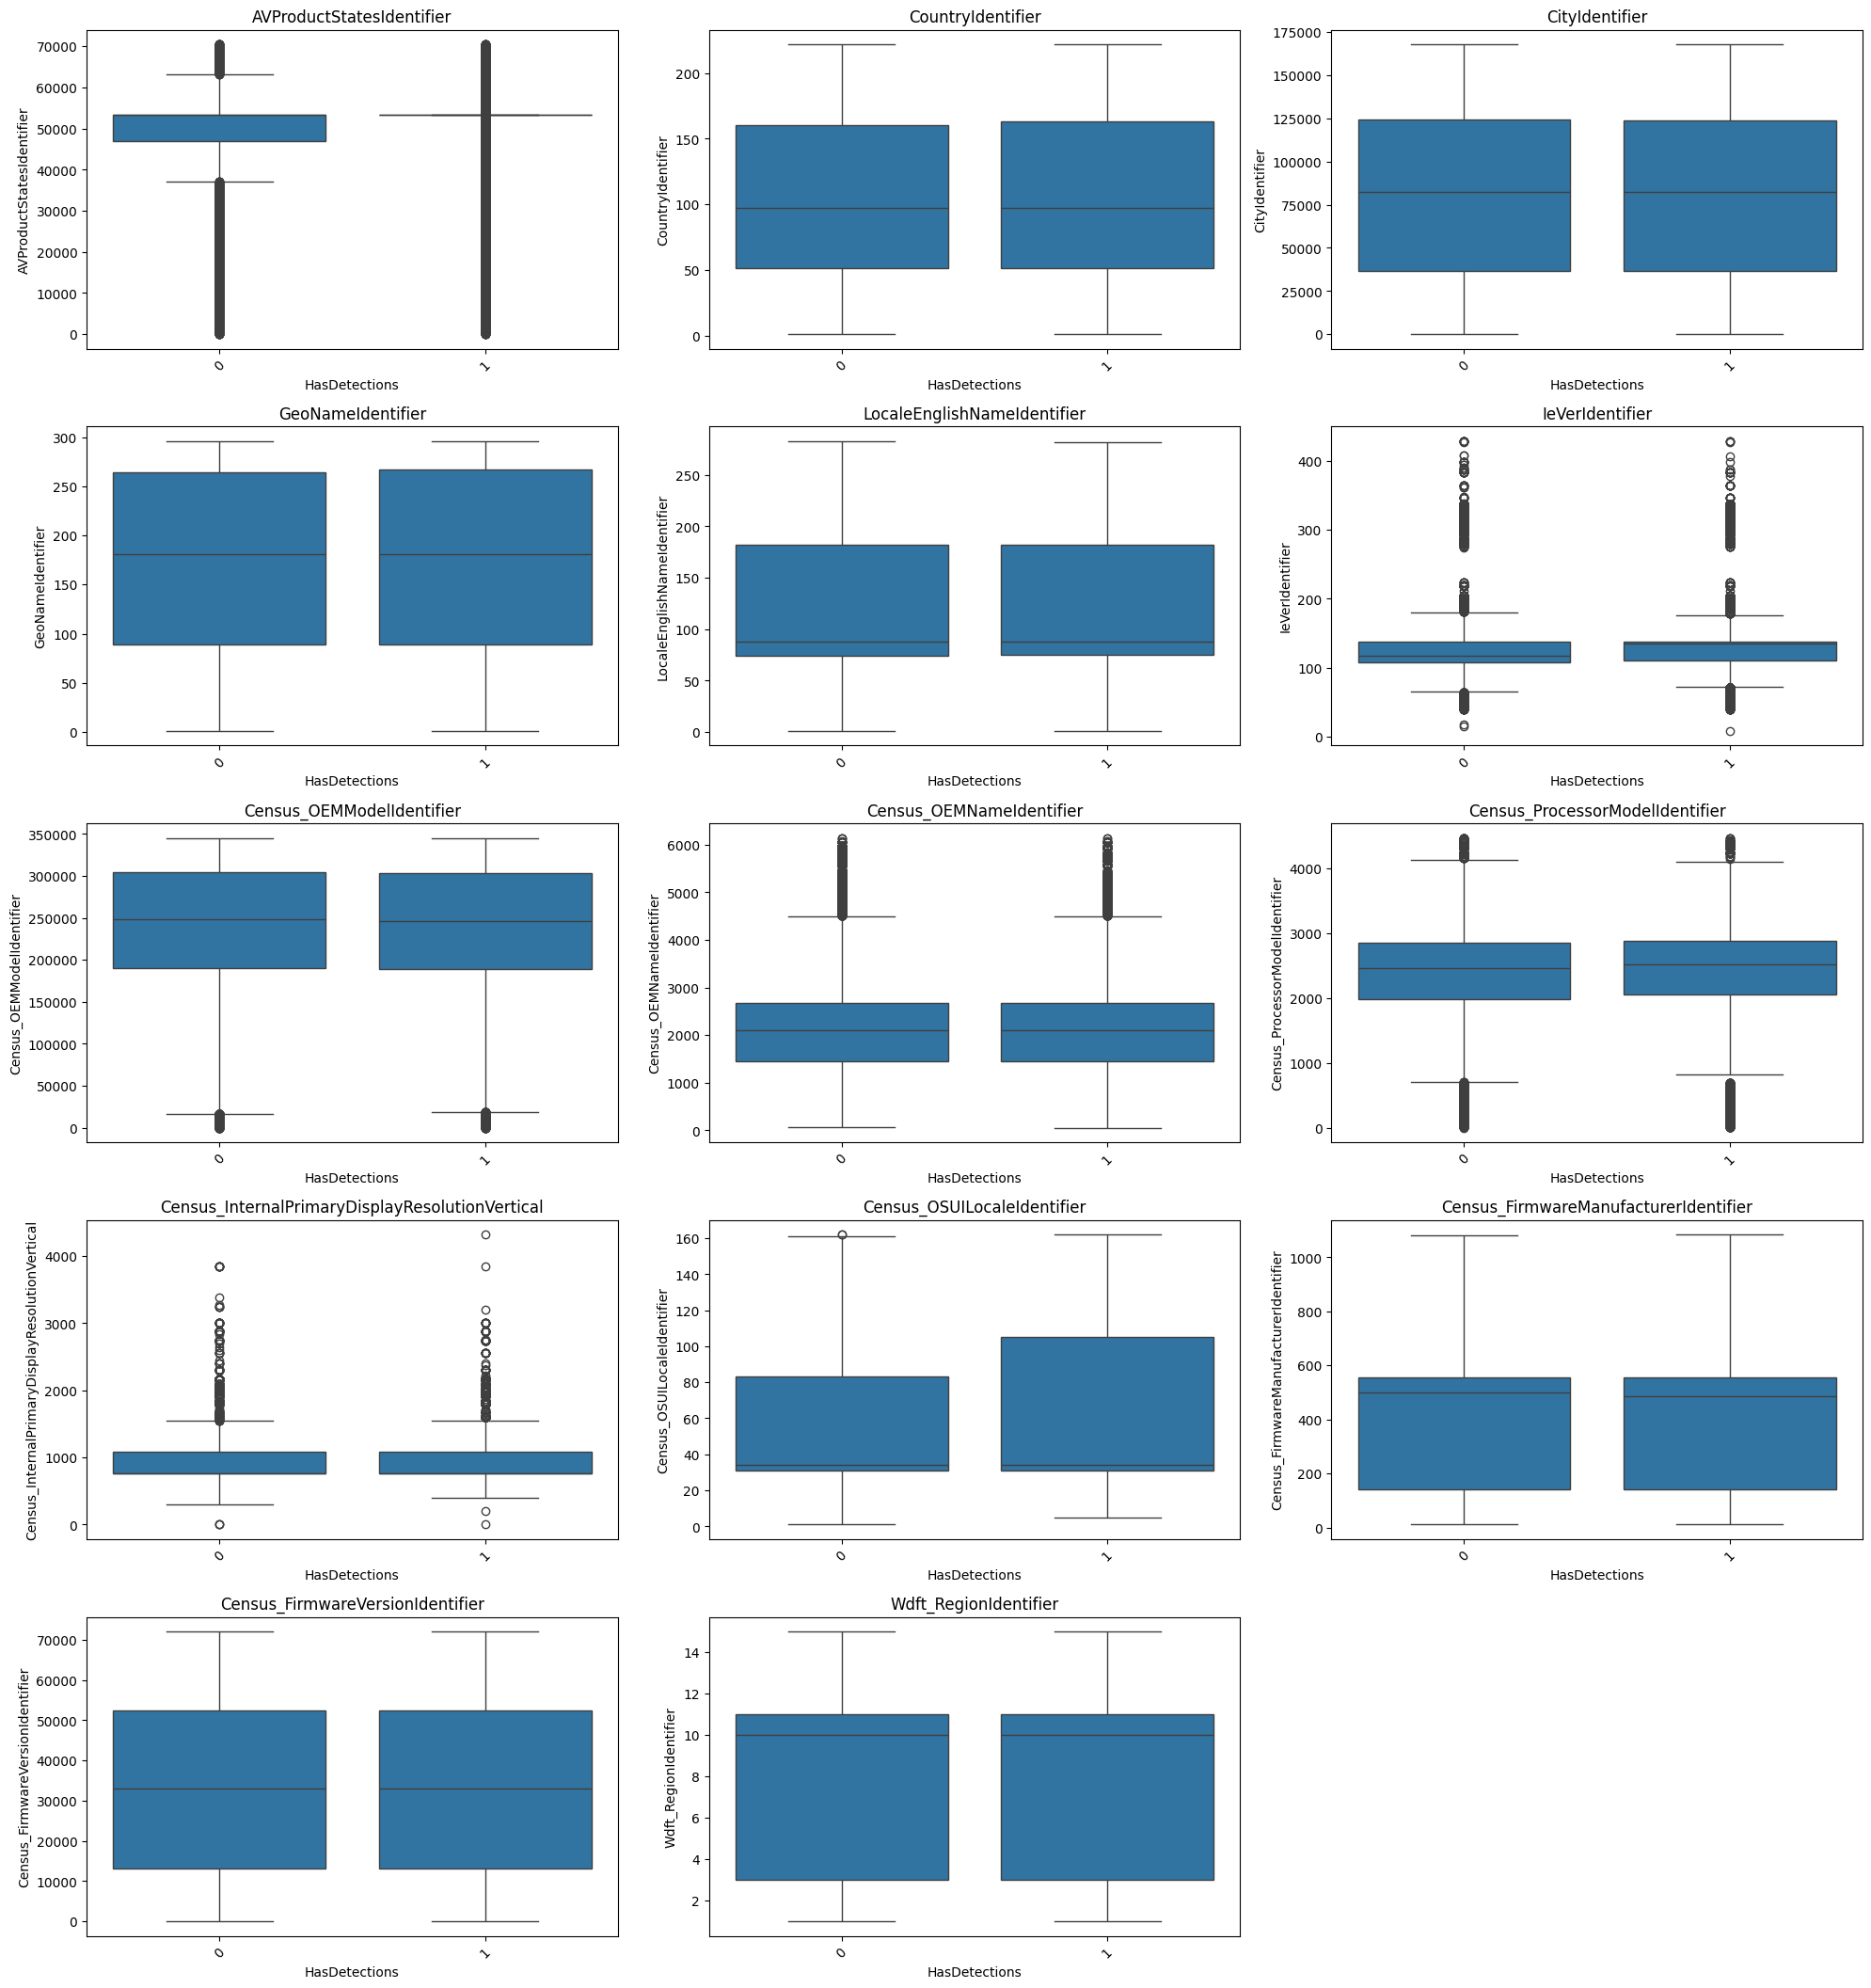

In [328]:
tar = 'HasDetections'
filas, cols_grid = 6, 3
fig, axes = plt.subplots(filas, cols_grid, figsize=(20, 25))
axes = axes.flatten()  # para recorrer fácilmente

# Recorrer columnas y dibujar boxplot
for i, col in enumerate(lista_numericas_interesantes):
    if i < filas * cols_grid:
        sns.boxplot(x=tar, y=col, data=df2, ax=axes[i])
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', rotation=45)

# Si quedan subplots vacíos, los ocultamos
for j in range(i+1, filas*cols_grid):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [311]:
corr = df2.corr(numeric_only=True)
corr['HasDetections'].to_frame().style.background_gradient(cmap='coolwarm')
# No existe una correlacion directa con el target en los numeros 


,HasDetections
RtpStateBitfield,0.040312
AVProductStatesIdentifier,0.116182
AVProductsInstalled,-0.148793
AVProductsEnabled,-0.041950
CountryIdentifier,0.006653
CityIdentifier,-0.004530
OrganizationIdentifier,0.005415
GeoNameIdentifier,0.003414
LocaleEnglishNameIdentifier,0.017020
OsBuild,0.024420


In [312]:
df2[lista_categoricas].select_dtypes(include=['object']).describe().T


,count,unique,top,freq
OsPlatformSubRelease,499964,9,rs4,220761
SkuEdition,499964,8,Home,308562
SmartScreen,321398,12,RequireAdmin,241591
Census_MDC2FormFactor,499964,12,Notebook,320940
Census_PrimaryDiskTypeName,499255,4,HDD,325410
Census_PowerPlatformRoleName,499962,9,Mobile,346369
Census_OSInstallTypeName,499964,9,UUPUpgrade,146778
Census_OSWUAutoUpdateOptionsName,499964,6,FullAuto,222466
Census_GenuineStateName,499964,4,IS_GENUINE,441375
Census_ActivationChannel,499964,6,Retail,264918


In [313]:
df2[lista_categoricas].isnull().sum()

OsPlatformSubRelease                     0
SkuEdition                               0
SmartScreen                         178566
Census_MDC2FormFactor                    0
Census_PrimaryDiskTypeName             709
Census_PowerPlatformRoleName             2
Census_OSInstallTypeName                 0
Census_OSWUAutoUpdateOptionsName         0
Census_GenuineStateName                  0
Census_ActivationChannel                 0
dtype: int64

In [314]:
df2[lista_boolean].astype(str).select_dtypes(include=['object']).describe().T


,count,unique,top,freq
Census_IsSecureBootEnabled,499964,2,0,257262
Census_IsTouchEnabled,499964,2,0,437248


In [315]:
(df2[lista_boolean].sum()/df2.shape[0])*100


Census_IsSecureBootEnabled    48.543895
Census_IsTouchEnabled         12.544103
dtype: float64

In [316]:
df2.head(3)

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSBuildRevision,Census_OSInstallTypeName,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,7.0,53447.0,1.0,1.0,8,85219.0,NaN,205.0,172,17134,256,rs4,Pro,1.0,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,1443.0,275891.0,4.0,2273.0,HDD,952838.0,8192.0,23.0,1080.0,Desktop,4.294967e+09,165,UUPUpgrade,120,FullAuto,IS_GENUINE,OEM:DM,0.0,NaN,355.0,19951.0,0,0.0,0,0.0,0.0,11.0,1
1,7.0,53447.0,1.0,1.0,129,54198.0,NaN,126.0,124,17134,256,rs4,Pro,1.0,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,2102.0,248850.0,4.0,2660.0,HDD,457600.0,8192.0,13.2,720.0,Mobile,0.000000e+00,165,UUPUpgrade,72,FullAuto,IS_GENUINE,OEM:DM,0.0,0.0,486.0,48753.0,0,0.0,0,0.0,1.0,3.0,0
2,7.0,46781.0,2.0,1.0,149,122689.0,27.0,181.0,56,10586,768,th2,Home,1.0,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,2206.0,238234.0,4.0,2998.0,SSD,221251.0,8192.0,15.5,1080.0,Mobile,0.000000e+00,1176,Update,109,Notify,IS_GENUINE,Retail,0.0,0.0,554.0,33111.0,1,0.0,1,0.0,0.0,15.0,0


In [317]:
df_limpio = df2.copy()

### c) REALIZO LA SEPRACION DE TEST Y TRAIN

In [318]:
X_train, X_test, Y_train, Y_test = train_test_split(df_limpio.drop('HasDetections', axis=1),
                                                    df_limpio['HasDetections'], test_size=0.2)


In [319]:
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(
    X_train, target)


In [320]:
print(lista_numericas)
print(len(lista_numericas))
print("\n ", lista_boolean)
print(len(lista_boolean))
print("\n ", lista_categoricas)
print(len(lista_categoricas))


['RtpStateBitfield', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'SMode', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorModelIdentifier', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildRevision', 'Census_OSUILocaleIdentifier', 'Census_IsFlightsDisabled', 'Census_ThresholdOptIn', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Census_IsVirtualDevice', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer', 'Wdft_RegionIdentifier']
35

  ['Census_IsSecureBootEnabled', 'Census_IsTouchEnabled']
2

  ['O

Creo variables que ayudan a reconocer en el pipeline

In [321]:

lista_numericas_f2 = list(map(lambda c: "mean_impute__" + c, lista_numericas))

lista_categoricas_f2 = list( map(lambda c: "moda_impute__" + c, lista_categoricas))


creao el pipeline:

In [322]:

ct_impute = ColumnTransformer(
    transformers=[
        ("mean_impute", SimpleImputer(strategy="mean"), lista_numericas),
        ("moda_impute", SimpleImputer(strategy="most_frequent"), lista_categoricas),

    ],
    remainder="passthrough"

)


ct_fe = ColumnTransformer(
    transformers=[
        ("standard", StandardScaler(), lista_numericas_f2),
        ("ohe", OneHotEncoder(sparse_output=False), lista_categoricas_f2),
    ],
    remainder="passthrough"
)

pipe = Pipeline(
    steps=[
        ("impute", ct_impute),
        ("fe", ct_fe)
    ]
)


Genero los fit del pipeline

In [323]:
Xt=pipe.fit_transform(X_train)
y_t = pipe.transform(X_test)


Evaluo las mejores 40 categorias

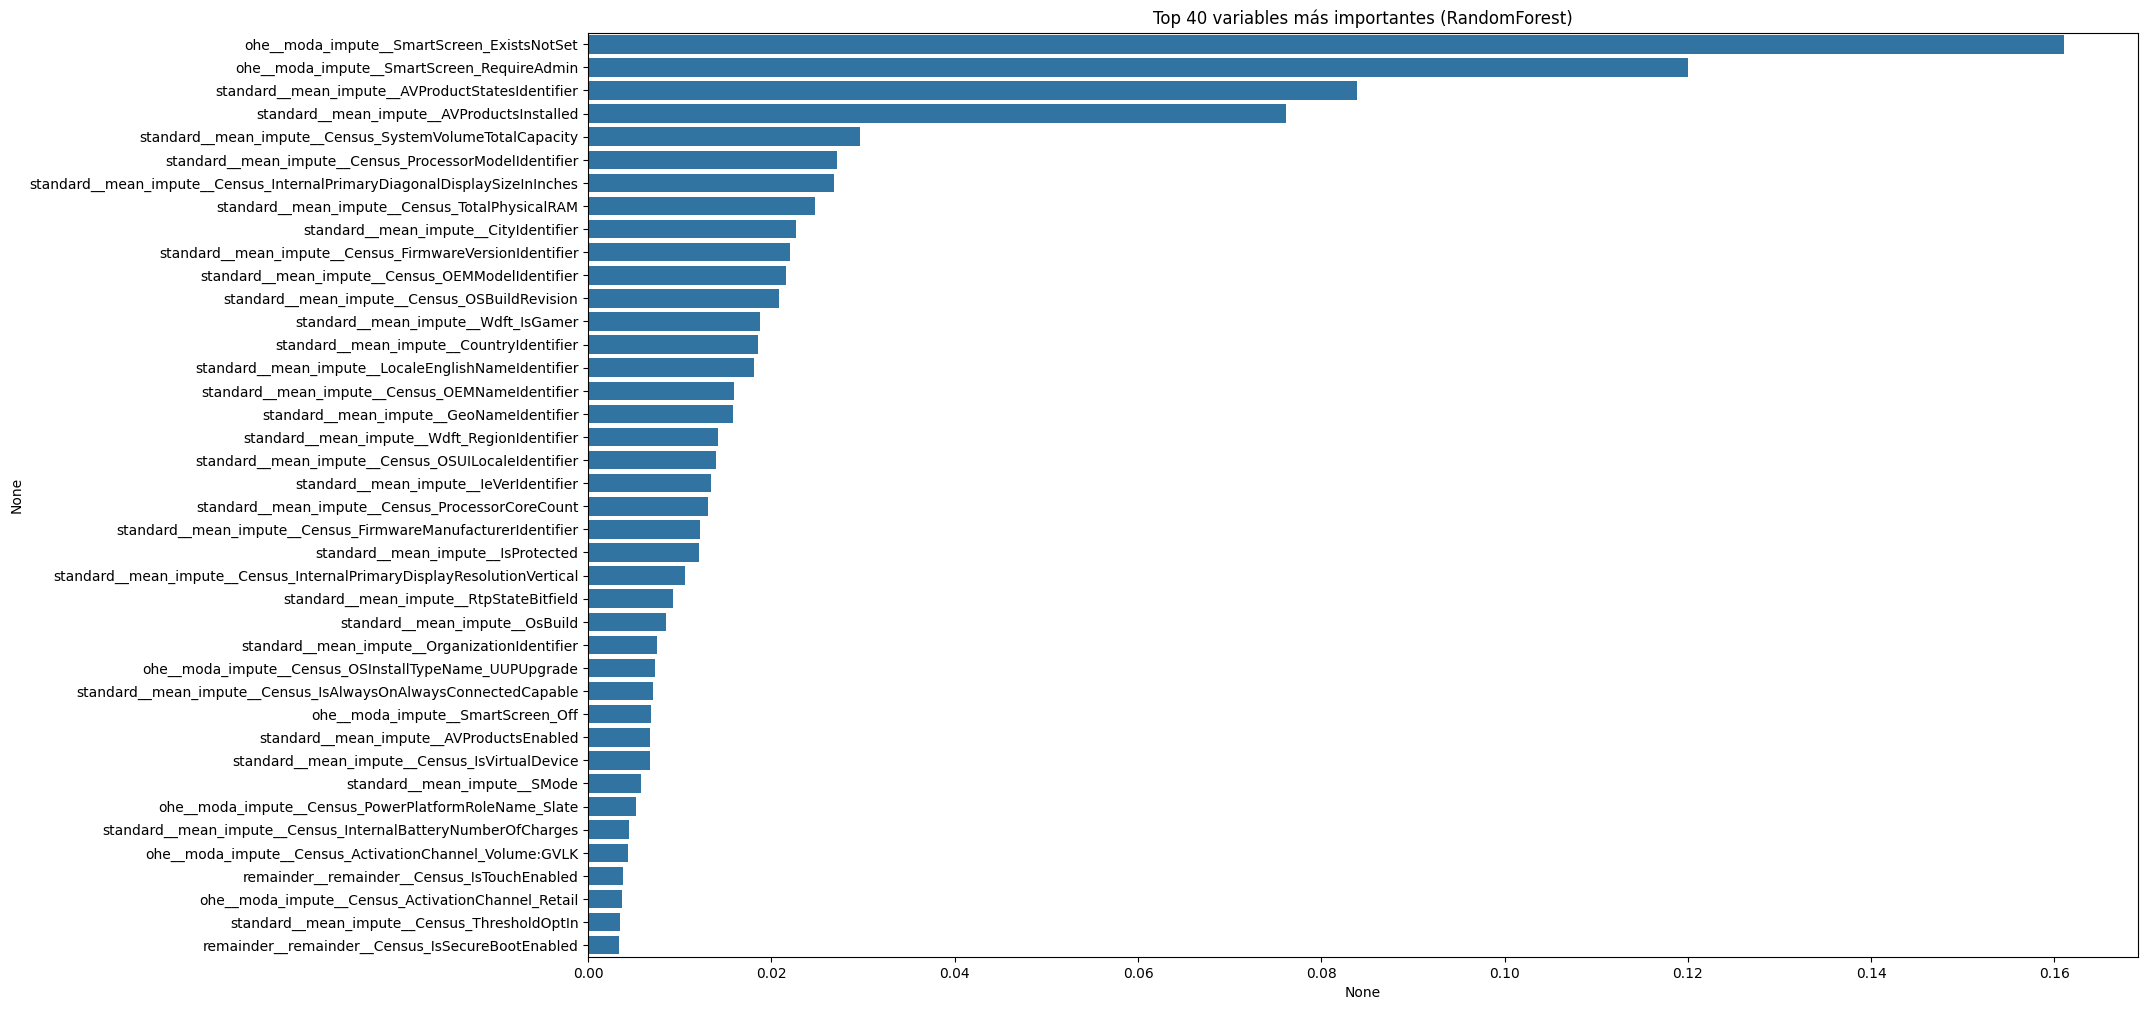

Número de variables seleccionadas: 40
Top features: ['ohe__moda_impute__SmartScreen_ExistsNotSet', 'ohe__moda_impute__SmartScreen_RequireAdmin', 'standard__mean_impute__AVProductStatesIdentifier', 'standard__mean_impute__AVProductsInstalled', 'standard__mean_impute__Census_SystemVolumeTotalCapacity', 'standard__mean_impute__Census_ProcessorModelIdentifier', 'standard__mean_impute__Census_InternalPrimaryDiagonalDisplaySizeInInches', 'standard__mean_impute__Census_TotalPhysicalRAM', 'standard__mean_impute__CityIdentifier', 'standard__mean_impute__Census_FirmwareVersionIdentifier']


In [324]:
from sklearn.ensemble import RandomForestClassifier as RFC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Instancio el algoritmo
rf = RFC(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(Xt, Y_train)     # Ajusto o entreno el algoritmo
importancias = pd.Series(rf.feature_importances_,
                         index=Xt.columns).sort_values(ascending=False)


# Visualización de las 20 variables más importantes
plt.figure(figsize=(20, 12))
sns.barplot(x=importancias.head(40), y=importancias.head(40).index)
plt.title("Top 40 variables más importantes (RandomForest)")
plt.show()

# Seleccionamos top variables (por ejemplo top 30)
top_vars = importancias.head(40).index.tolist()
X_reducido = Xt[top_vars]

print(f"Número de variables seleccionadas: {len(top_vars)}")
print("Top features:", top_vars[:10])


Filtro las 40 categorias en mis dataset de train y test

In [325]:


df_val = importancias.reset_index()
df_val.columns = ['atributos', 'valor']
atributos_finales = df_val['atributos'].head(40).tolist()



In [326]:
Xt_t = Xt[atributos_finales]

y_tt = y_t[atributos_finales]

Genero una evalucion de diferentes modelos

In [329]:
modelos = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=50),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, max_depth=3),
    "XGBClassifier": xgb.XGBClassifier(n_estimators=100, max_depth=3 )
}

resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(Xt_t, Y_train)
    y_pred = modelo.predict(y_tt)
    acc = accuracy_score(Y_test, y_pred)
    resultados[nombre] = acc
    print(f"\n🔹 Modelo: {nombre}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(Y_test, y_pred))



🔹 Modelo: Decision Tree
Accuracy: 0.6220
              precision    recall  f1-score   support

           0       0.63      0.58      0.61     49847
           1       0.61      0.66      0.64     50146

    accuracy                           0.62     99993
   macro avg       0.62      0.62      0.62     99993
weighted avg       0.62      0.62      0.62     99993


🔹 Modelo: Random Forest
Accuracy: 0.6251
              precision    recall  f1-score   support

           0       0.63      0.61      0.62     49847
           1       0.62      0.64      0.63     50146

    accuracy                           0.63     99993
   macro avg       0.63      0.63      0.62     99993
weighted avg       0.63      0.63      0.62     99993


🔹 Modelo: Gradient Boosting
Accuracy: 0.6282
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     49847
           1       0.63      0.63      0.63     50146

    accuracy                           0.63     9999

Evaluo una curva de ROC

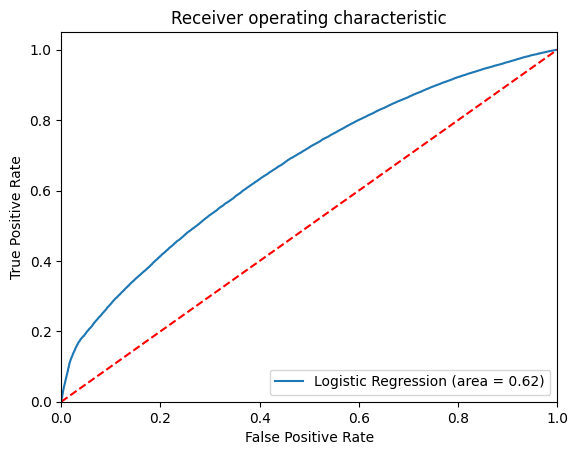

In [330]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score)

lr = LogisticRegression()
lr.fit(Xt_t, Y_train)

logit_roc_auc = roc_auc_score(Y_test, lr.predict(y_tt))
fpr, tpr, thresholds = roc_curve(Y_test, lr.predict_proba(y_tt)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
